In [9]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
from gua_functions import _apply_wavelet_denoising_feature, apply_wavelet_denoising_row, create_windows,apply_wavelet_denoising, moving_avg,strip_front,create_synced_windows,get_features_and_labels,create_features_sectioned_pipe,create_synced_windows_interpol
from gua_enums import *

import InteractiveLegend 
import pywt
import pickle
from sklearn import ensemble
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import classification_report
from sklearn.calibration import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn import multiclass
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
import json
from pprint import pp
from tqdm import tqdm
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold, cross_validate
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
def mprint(data):
    print(json.dumps(data, cls=NumpyEncoder, indent=4))

In [63]:
df = pd.read_pickle('combined_all_interpol_synced_4sec_800samples_prot4.pkl')
row = df.iloc[0]
for feature in row.index:
    print(f'Shape of feature {feature}: {np.shape(row[feature])}')


Shape of feature uid: ()
Shape of feature sensordata.ACC: (800, 3)
Shape of feature sensordata.GYR: (800, 3)
Shape of feature sensordata.GRV: (800, 3)
Shape of feature sensordata.MAG: (800, 3)
Shape of feature sensordata.ROT: (800, 5)
Shape of feature duration: ()


In [20]:
sensor_names = []
for sn in SensorEnum.valid():
    sensor_names.append(sn.name)

In [64]:
"""
Creates the features from sensordata, for each dimension.
"""
import scipy


def create_section_features(data_arr: np.ndarray,f0=0)->np.ndarray:
    data_arr = data_arr.squeeze()
    features = np.array([])
    #print(data_arr.shape)
    if len(data_arr.shape) > 1:
        for dim in range(data_arr.shape[-1]):
            features = np.append(features, create_section_features(data_arr[:,dim],f0))
    else:
        h_data_arr = data_arr * np.hanning(len(data_arr))
        h_fft = np.fft.rfft(h_data_arr)
        S = np.abs(h_fft**2)/len(df)
        
        sum_S = np.sum(S)
        mean_S = np.mean(S)
        var_S = np.var(S)
        
        features = np.append(features,[sum_S,mean_S,var_S])
    return features

def create_old_features(data_arr: np.ndarray)->np.ndarray:
    features = np.array([])
    h_data_arr = np.zeros(data_arr.shape)
    #all_names=[]
    peak_count = 5
    dimsize = data_arr.shape[-1]
    for dim in range(0, dimsize) :
        h_data_arr[:,dim] = data_arr[:,dim] * np.hanning(data_arr.shape[0])
    for dim in range(0, dimsize) :
        [fk,psd] = scipy.signal.periodogram(h_data_arr[:,dim],scaling="density")
        dimstats=np.asarray([
                np.mean(h_data_arr[:,dim]),
                np.var(h_data_arr[:,dim]),
                np.std(h_data_arr[:,dim]),
                scipy.stats.kurtosis(h_data_arr[:,dim]),
                scipy.stats.skew(h_data_arr[:,dim]),
                np.sqrt(np.mean([v**2 for v in h_data_arr[:,dim] ]))])
        #fnames = ['mean_'+str(dim),'var_'+str(dim),'std_'+str(dim),'kurt_'+str(dim),'skew_'+str(dim),'rms_'+str(dim)]
        corr = scipy.signal.correlate(h_data_arr[:,dim],h_data_arr[:,(dim+1)%dimsize])
        dimstats = np.append(dimstats,[
                np.mean(corr),
                np.var(corr),
                np.std(corr)])
        #fnames = fnames + ['mean_corr_'+str(dim),'var_corr_'+str(dim),'std_corr_'+str(dim)]
        peaks = psd[scipy.signal.find_peaks(psd)[0]][0:peak_count]
        if len(peaks) < peak_count:
            peaks = np.append(peaks, np.zeros(peak_count-len(peaks)))
        dimstats = np.append(dimstats,peaks)
        #fnames = fnames + ['peak'+str(i)+'_'+str(dim) for i in range(peak_count)]
        features = np.append(features, dimstats)
        #all_names = all_names + fnames
        #print(f'Feature shape: {features.shape}')
    return features#,all_names
def create_old_feature_names(data_arr: np.ndarray)->np.ndarray:
    all_names=[]
    peak_count = 5
    dimsize = data_arr.shape[-1]
    for dim in range(0, dimsize) :
        fnames = ['mean_'+str(dim),'var_'+str(dim),'std_'+str(dim),'kurt_'+str(dim),'skew_'+str(dim),'rms_'+str(dim)]
        fnames = fnames + ['mean_corr_'+str(dim),'var_corr_'+str(dim),'std_corr_'+str(dim)]
        fnames = fnames + ['peak'+str(i)+'_'+str(dim) for i in range(peak_count)]
        all_names = all_names + fnames
        
    return all_names


    

In [22]:
all_fnames=['LCC_mean_0_sec_0',
 'LCC_var_0_sec_0',
 'LCC_std_0_sec_0',
 'LCC_kurt_0_sec_0',
 'LCC_skew_0_sec_0',
 'LCC_rms_0_sec_0',
 'LCC_mean_corr_0_sec_0',
 'LCC_var_corr_0_sec_0',
 'LCC_std_corr_0_sec_0',
 'LCC_peak0_0_sec_0',
 'LCC_peak1_0_sec_0',
 'LCC_peak2_0_sec_0',
 'LCC_peak3_0_sec_0',
 'LCC_peak4_0_sec_0',
 'LCC_mean_1_sec_0',
 'LCC_var_1_sec_0',
 'LCC_std_1_sec_0',
 'LCC_kurt_1_sec_0',
 'LCC_skew_1_sec_0',
 'LCC_rms_1_sec_0',
 'LCC_mean_corr_1_sec_0',
 'LCC_var_corr_1_sec_0',
 'LCC_std_corr_1_sec_0',
 'LCC_peak0_1_sec_0',
 'LCC_peak1_1_sec_0',
 'LCC_peak2_1_sec_0',
 'LCC_peak3_1_sec_0',
 'LCC_peak4_1_sec_0',
 'LCC_mean_2_sec_0',
 'LCC_var_2_sec_0',
 'LCC_std_2_sec_0',
 'LCC_kurt_2_sec_0',
 'LCC_skew_2_sec_0',
 'LCC_rms_2_sec_0',
 'LCC_mean_corr_2_sec_0',
 'LCC_var_corr_2_sec_0',
 'LCC_std_corr_2_sec_0',
 'LCC_peak0_2_sec_0',
 'LCC_peak1_2_sec_0',
 'LCC_peak2_2_sec_0',
 'LCC_peak3_2_sec_0',
 'LCC_peak4_2_sec_0',
 'ACC_mean_0_sec_0',
 'ACC_var_0_sec_0',
 'ACC_std_0_sec_0',
 'ACC_kurt_0_sec_0',
 'ACC_skew_0_sec_0',
 'ACC_rms_0_sec_0',
 'ACC_mean_corr_0_sec_0',
 'ACC_var_corr_0_sec_0',
 'ACC_std_corr_0_sec_0',
 'ACC_peak0_0_sec_0',
 'ACC_peak1_0_sec_0',
 'ACC_peak2_0_sec_0',
 'ACC_peak3_0_sec_0',
 'ACC_peak4_0_sec_0',
 'ACC_mean_1_sec_0',
 'ACC_var_1_sec_0',
 'ACC_std_1_sec_0',
 'ACC_kurt_1_sec_0',
 'ACC_skew_1_sec_0',
 'ACC_rms_1_sec_0',
 'ACC_mean_corr_1_sec_0',
 'ACC_var_corr_1_sec_0',
 'ACC_std_corr_1_sec_0',
 'ACC_peak0_1_sec_0',
 'ACC_peak1_1_sec_0',
 'ACC_peak2_1_sec_0',
 'ACC_peak3_1_sec_0',
 'ACC_peak4_1_sec_0',
 'ACC_mean_2_sec_0',
 'ACC_var_2_sec_0',
 'ACC_std_2_sec_0',
 'ACC_kurt_2_sec_0',
 'ACC_skew_2_sec_0',
 'ACC_rms_2_sec_0',
 'ACC_mean_corr_2_sec_0',
 'ACC_var_corr_2_sec_0',
 'ACC_std_corr_2_sec_0',
 'ACC_peak0_2_sec_0',
 'ACC_peak1_2_sec_0',
 'ACC_peak2_2_sec_0',
 'ACC_peak3_2_sec_0',
 'ACC_peak4_2_sec_0',
 'GYR_mean_0_sec_0',
 'GYR_var_0_sec_0',
 'GYR_std_0_sec_0',
 'GYR_kurt_0_sec_0',
 'GYR_skew_0_sec_0',
 'GYR_rms_0_sec_0',
 'GYR_mean_corr_0_sec_0',
 'GYR_var_corr_0_sec_0',
 'GYR_std_corr_0_sec_0',
 'GYR_peak0_0_sec_0',
 'GYR_peak1_0_sec_0',
 'GYR_peak2_0_sec_0',
 'GYR_peak3_0_sec_0',
 'GYR_peak4_0_sec_0',
 'GYR_mean_1_sec_0',
 'GYR_var_1_sec_0',
 'GYR_std_1_sec_0',
 'GYR_kurt_1_sec_0',
 'GYR_skew_1_sec_0',
 'GYR_rms_1_sec_0',
 'GYR_mean_corr_1_sec_0',
 'GYR_var_corr_1_sec_0',
 'GYR_std_corr_1_sec_0',
 'GYR_peak0_1_sec_0',
 'GYR_peak1_1_sec_0',
 'GYR_peak2_1_sec_0',
 'GYR_peak3_1_sec_0',
 'GYR_peak4_1_sec_0',
 'GYR_mean_2_sec_0',
 'GYR_var_2_sec_0',
 'GYR_std_2_sec_0',
 'GYR_kurt_2_sec_0',
 'GYR_skew_2_sec_0',
 'GYR_rms_2_sec_0',
 'GYR_mean_corr_2_sec_0',
 'GYR_var_corr_2_sec_0',
 'GYR_std_corr_2_sec_0',
 'GYR_peak0_2_sec_0',
 'GYR_peak1_2_sec_0',
 'GYR_peak2_2_sec_0',
 'GYR_peak3_2_sec_0',
 'GYR_peak4_2_sec_0',
 'GRV_mean_0_sec_0',
 'GRV_var_0_sec_0',
 'GRV_std_0_sec_0',
 'GRV_kurt_0_sec_0',
 'GRV_skew_0_sec_0',
 'GRV_rms_0_sec_0',
 'GRV_mean_corr_0_sec_0',
 'GRV_var_corr_0_sec_0',
 'GRV_std_corr_0_sec_0',
 'GRV_peak0_0_sec_0',
 'GRV_peak1_0_sec_0',
 'GRV_peak2_0_sec_0',
 'GRV_peak3_0_sec_0',
 'GRV_peak4_0_sec_0',
 'GRV_mean_1_sec_0',
 'GRV_var_1_sec_0',
 'GRV_std_1_sec_0',
 'GRV_kurt_1_sec_0',
 'GRV_skew_1_sec_0',
 'GRV_rms_1_sec_0',
 'GRV_mean_corr_1_sec_0',
 'GRV_var_corr_1_sec_0',
 'GRV_std_corr_1_sec_0',
 'GRV_peak0_1_sec_0',
 'GRV_peak1_1_sec_0',
 'GRV_peak2_1_sec_0',
 'GRV_peak3_1_sec_0',
 'GRV_peak4_1_sec_0',
 'GRV_mean_2_sec_0',
 'GRV_var_2_sec_0',
 'GRV_std_2_sec_0',
 'GRV_kurt_2_sec_0',
 'GRV_skew_2_sec_0',
 'GRV_rms_2_sec_0',
 'GRV_mean_corr_2_sec_0',
 'GRV_var_corr_2_sec_0',
 'GRV_std_corr_2_sec_0',
 'GRV_peak0_2_sec_0',
 'GRV_peak1_2_sec_0',
 'GRV_peak2_2_sec_0',
 'GRV_peak3_2_sec_0',
 'GRV_peak4_2_sec_0',
 'MAG_mean_0_sec_0',
 'MAG_var_0_sec_0',
 'MAG_std_0_sec_0',
 'MAG_kurt_0_sec_0',
 'MAG_skew_0_sec_0',
 'MAG_rms_0_sec_0',
 'MAG_mean_corr_0_sec_0',
 'MAG_var_corr_0_sec_0',
 'MAG_std_corr_0_sec_0',
 'MAG_peak0_0_sec_0',
 'MAG_peak1_0_sec_0',
 'MAG_peak2_0_sec_0',
 'MAG_peak3_0_sec_0',
 'MAG_peak4_0_sec_0',
 'MAG_mean_1_sec_0',
 'MAG_var_1_sec_0',
 'MAG_std_1_sec_0',
 'MAG_kurt_1_sec_0',
 'MAG_skew_1_sec_0',
 'MAG_rms_1_sec_0',
 'MAG_mean_corr_1_sec_0',
 'MAG_var_corr_1_sec_0',
 'MAG_std_corr_1_sec_0',
 'MAG_peak0_1_sec_0',
 'MAG_peak1_1_sec_0',
 'MAG_peak2_1_sec_0',
 'MAG_peak3_1_sec_0',
 'MAG_peak4_1_sec_0',
 'MAG_mean_2_sec_0',
 'MAG_var_2_sec_0',
 'MAG_std_2_sec_0',
 'MAG_kurt_2_sec_0',
 'MAG_skew_2_sec_0',
 'MAG_rms_2_sec_0',
 'MAG_mean_corr_2_sec_0',
 'MAG_var_corr_2_sec_0',
 'MAG_std_corr_2_sec_0',
 'MAG_peak0_2_sec_0',
 'MAG_peak1_2_sec_0',
 'MAG_peak2_2_sec_0',
 'MAG_peak3_2_sec_0',
 'MAG_peak4_2_sec_0',
 'ROT_mean_0_sec_0',
 'ROT_var_0_sec_0',
 'ROT_std_0_sec_0',
 'ROT_kurt_0_sec_0',
 'ROT_skew_0_sec_0',
 'ROT_rms_0_sec_0',
 'ROT_mean_corr_0_sec_0',
 'ROT_var_corr_0_sec_0',
 'ROT_std_corr_0_sec_0',
 'ROT_peak0_0_sec_0',
 'ROT_peak1_0_sec_0',
 'ROT_peak2_0_sec_0',
 'ROT_peak3_0_sec_0',
 'ROT_peak4_0_sec_0',
 'ROT_mean_1_sec_0',
 'ROT_var_1_sec_0',
 'ROT_std_1_sec_0',
 'ROT_kurt_1_sec_0',
 'ROT_skew_1_sec_0',
 'ROT_rms_1_sec_0',
 'ROT_mean_corr_1_sec_0',
 'ROT_var_corr_1_sec_0',
 'ROT_std_corr_1_sec_0',
 'ROT_peak0_1_sec_0',
 'ROT_peak1_1_sec_0',
 'ROT_peak2_1_sec_0',
 'ROT_peak3_1_sec_0',
 'ROT_peak4_1_sec_0',
 'ROT_mean_2_sec_0',
 'ROT_var_2_sec_0',
 'ROT_std_2_sec_0',
 'ROT_kurt_2_sec_0',
 'ROT_skew_2_sec_0',
 'ROT_rms_2_sec_0',
 'ROT_mean_corr_2_sec_0',
 'ROT_var_corr_2_sec_0',
 'ROT_std_corr_2_sec_0',
 'ROT_peak0_2_sec_0',
 'ROT_peak1_2_sec_0',
 'ROT_peak2_2_sec_0',
 'ROT_peak3_2_sec_0',
 'ROT_peak4_2_sec_0',
 'ROT_mean_3_sec_0',
 'ROT_var_3_sec_0',
 'ROT_std_3_sec_0',
 'ROT_kurt_3_sec_0',
 'ROT_skew_3_sec_0',
 'ROT_rms_3_sec_0',
 'ROT_mean_corr_3_sec_0',
 'ROT_var_corr_3_sec_0',
 'ROT_std_corr_3_sec_0',
 'ROT_peak0_3_sec_0',
 'ROT_peak1_3_sec_0',
 'ROT_peak2_3_sec_0',
 'ROT_peak3_3_sec_0',
 'ROT_peak4_3_sec_0',
 'ROT_mean_4_sec_0',
 'ROT_var_4_sec_0',
 'ROT_std_4_sec_0',
 'ROT_kurt_4_sec_0',
 'ROT_skew_4_sec_0',
 'ROT_rms_4_sec_0',
 'ROT_mean_corr_4_sec_0',
 'ROT_var_corr_4_sec_0',
 'ROT_std_corr_4_sec_0',
 'ROT_peak0_4_sec_0',
 'ROT_peak1_4_sec_0',
 'ROT_peak2_4_sec_0',
 'ROT_peak3_4_sec_0',
 'ROT_peak4_4_sec_0',
 'LCC_mean_0_sec_1',
 'LCC_var_0_sec_1',
 'LCC_std_0_sec_1',
 'LCC_kurt_0_sec_1',
 'LCC_skew_0_sec_1',
 'LCC_rms_0_sec_1',
 'LCC_mean_corr_0_sec_1',
 'LCC_var_corr_0_sec_1',
 'LCC_std_corr_0_sec_1',
 'LCC_peak0_0_sec_1',
 'LCC_peak1_0_sec_1',
 'LCC_peak2_0_sec_1',
 'LCC_peak3_0_sec_1',
 'LCC_peak4_0_sec_1',
 'LCC_mean_1_sec_1',
 'LCC_var_1_sec_1',
 'LCC_std_1_sec_1',
 'LCC_kurt_1_sec_1',
 'LCC_skew_1_sec_1',
 'LCC_rms_1_sec_1',
 'LCC_mean_corr_1_sec_1',
 'LCC_var_corr_1_sec_1',
 'LCC_std_corr_1_sec_1',
 'LCC_peak0_1_sec_1',
 'LCC_peak1_1_sec_1',
 'LCC_peak2_1_sec_1',
 'LCC_peak3_1_sec_1',
 'LCC_peak4_1_sec_1',
 'LCC_mean_2_sec_1',
 'LCC_var_2_sec_1',
 'LCC_std_2_sec_1',
 'LCC_kurt_2_sec_1',
 'LCC_skew_2_sec_1',
 'LCC_rms_2_sec_1',
 'LCC_mean_corr_2_sec_1',
 'LCC_var_corr_2_sec_1',
 'LCC_std_corr_2_sec_1',
 'LCC_peak0_2_sec_1',
 'LCC_peak1_2_sec_1',
 'LCC_peak2_2_sec_1',
 'LCC_peak3_2_sec_1',
 'LCC_peak4_2_sec_1',
 'ACC_mean_0_sec_1',
 'ACC_var_0_sec_1',
 'ACC_std_0_sec_1',
 'ACC_kurt_0_sec_1',
 'ACC_skew_0_sec_1',
 'ACC_rms_0_sec_1',
 'ACC_mean_corr_0_sec_1',
 'ACC_var_corr_0_sec_1',
 'ACC_std_corr_0_sec_1',
 'ACC_peak0_0_sec_1',
 'ACC_peak1_0_sec_1',
 'ACC_peak2_0_sec_1',
 'ACC_peak3_0_sec_1',
 'ACC_peak4_0_sec_1',
 'ACC_mean_1_sec_1',
 'ACC_var_1_sec_1',
 'ACC_std_1_sec_1',
 'ACC_kurt_1_sec_1',
 'ACC_skew_1_sec_1',
 'ACC_rms_1_sec_1',
 'ACC_mean_corr_1_sec_1',
 'ACC_var_corr_1_sec_1',
 'ACC_std_corr_1_sec_1',
 'ACC_peak0_1_sec_1',
 'ACC_peak1_1_sec_1',
 'ACC_peak2_1_sec_1',
 'ACC_peak3_1_sec_1',
 'ACC_peak4_1_sec_1',
 'ACC_mean_2_sec_1',
 'ACC_var_2_sec_1',
 'ACC_std_2_sec_1',
 'ACC_kurt_2_sec_1',
 'ACC_skew_2_sec_1',
 'ACC_rms_2_sec_1',
 'ACC_mean_corr_2_sec_1',
 'ACC_var_corr_2_sec_1',
 'ACC_std_corr_2_sec_1',
 'ACC_peak0_2_sec_1',
 'ACC_peak1_2_sec_1',
 'ACC_peak2_2_sec_1',
 'ACC_peak3_2_sec_1',
 'ACC_peak4_2_sec_1',
 'GYR_mean_0_sec_1',
 'GYR_var_0_sec_1',
 'GYR_std_0_sec_1',
 'GYR_kurt_0_sec_1',
 'GYR_skew_0_sec_1',
 'GYR_rms_0_sec_1',
 'GYR_mean_corr_0_sec_1',
 'GYR_var_corr_0_sec_1',
 'GYR_std_corr_0_sec_1',
 'GYR_peak0_0_sec_1',
 'GYR_peak1_0_sec_1',
 'GYR_peak2_0_sec_1',
 'GYR_peak3_0_sec_1',
 'GYR_peak4_0_sec_1',
 'GYR_mean_1_sec_1',
 'GYR_var_1_sec_1',
 'GYR_std_1_sec_1',
 'GYR_kurt_1_sec_1',
 'GYR_skew_1_sec_1',
 'GYR_rms_1_sec_1',
 'GYR_mean_corr_1_sec_1',
 'GYR_var_corr_1_sec_1',
 'GYR_std_corr_1_sec_1',
 'GYR_peak0_1_sec_1',
 'GYR_peak1_1_sec_1',
 'GYR_peak2_1_sec_1',
 'GYR_peak3_1_sec_1',
 'GYR_peak4_1_sec_1',
 'GYR_mean_2_sec_1',
 'GYR_var_2_sec_1',
 'GYR_std_2_sec_1',
 'GYR_kurt_2_sec_1',
 'GYR_skew_2_sec_1',
 'GYR_rms_2_sec_1',
 'GYR_mean_corr_2_sec_1',
 'GYR_var_corr_2_sec_1',
 'GYR_std_corr_2_sec_1',
 'GYR_peak0_2_sec_1',
 'GYR_peak1_2_sec_1',
 'GYR_peak2_2_sec_1',
 'GYR_peak3_2_sec_1',
 'GYR_peak4_2_sec_1',
 'GRV_mean_0_sec_1',
 'GRV_var_0_sec_1',
 'GRV_std_0_sec_1',
 'GRV_kurt_0_sec_1',
 'GRV_skew_0_sec_1',
 'GRV_rms_0_sec_1',
 'GRV_mean_corr_0_sec_1',
 'GRV_var_corr_0_sec_1',
 'GRV_std_corr_0_sec_1',
 'GRV_peak0_0_sec_1',
 'GRV_peak1_0_sec_1',
 'GRV_peak2_0_sec_1',
 'GRV_peak3_0_sec_1',
 'GRV_peak4_0_sec_1',
 'GRV_mean_1_sec_1',
 'GRV_var_1_sec_1',
 'GRV_std_1_sec_1',
 'GRV_kurt_1_sec_1',
 'GRV_skew_1_sec_1',
 'GRV_rms_1_sec_1',
 'GRV_mean_corr_1_sec_1',
 'GRV_var_corr_1_sec_1',
 'GRV_std_corr_1_sec_1',
 'GRV_peak0_1_sec_1',
 'GRV_peak1_1_sec_1',
 'GRV_peak2_1_sec_1',
 'GRV_peak3_1_sec_1',
 'GRV_peak4_1_sec_1',
 'GRV_mean_2_sec_1',
 'GRV_var_2_sec_1',
 'GRV_std_2_sec_1',
 'GRV_kurt_2_sec_1',
 'GRV_skew_2_sec_1',
 'GRV_rms_2_sec_1',
 'GRV_mean_corr_2_sec_1',
 'GRV_var_corr_2_sec_1',
 'GRV_std_corr_2_sec_1',
 'GRV_peak0_2_sec_1',
 'GRV_peak1_2_sec_1',
 'GRV_peak2_2_sec_1',
 'GRV_peak3_2_sec_1',
 'GRV_peak4_2_sec_1',
 'MAG_mean_0_sec_1',
 'MAG_var_0_sec_1',
 'MAG_std_0_sec_1',
 'MAG_kurt_0_sec_1',
 'MAG_skew_0_sec_1',
 'MAG_rms_0_sec_1',
 'MAG_mean_corr_0_sec_1',
 'MAG_var_corr_0_sec_1',
 'MAG_std_corr_0_sec_1',
 'MAG_peak0_0_sec_1',
 'MAG_peak1_0_sec_1',
 'MAG_peak2_0_sec_1',
 'MAG_peak3_0_sec_1',
 'MAG_peak4_0_sec_1',
 'MAG_mean_1_sec_1',
 'MAG_var_1_sec_1',
 'MAG_std_1_sec_1',
 'MAG_kurt_1_sec_1',
 'MAG_skew_1_sec_1',
 'MAG_rms_1_sec_1',
 'MAG_mean_corr_1_sec_1',
 'MAG_var_corr_1_sec_1',
 'MAG_std_corr_1_sec_1',
 'MAG_peak0_1_sec_1',
 'MAG_peak1_1_sec_1',
 'MAG_peak2_1_sec_1',
 'MAG_peak3_1_sec_1',
 'MAG_peak4_1_sec_1',
 'MAG_mean_2_sec_1',
 'MAG_var_2_sec_1',
 'MAG_std_2_sec_1',
 'MAG_kurt_2_sec_1',
 'MAG_skew_2_sec_1',
 'MAG_rms_2_sec_1',
 'MAG_mean_corr_2_sec_1',
 'MAG_var_corr_2_sec_1',
 'MAG_std_corr_2_sec_1',
 'MAG_peak0_2_sec_1',
 'MAG_peak1_2_sec_1',
 'MAG_peak2_2_sec_1',
 'MAG_peak3_2_sec_1',
 'MAG_peak4_2_sec_1',
 'ROT_mean_0_sec_1',
 'ROT_var_0_sec_1',
 'ROT_std_0_sec_1',
 'ROT_kurt_0_sec_1',
 'ROT_skew_0_sec_1',
 'ROT_rms_0_sec_1',
 'ROT_mean_corr_0_sec_1',
 'ROT_var_corr_0_sec_1',
 'ROT_std_corr_0_sec_1',
 'ROT_peak0_0_sec_1',
 'ROT_peak1_0_sec_1',
 'ROT_peak2_0_sec_1',
 'ROT_peak3_0_sec_1',
 'ROT_peak4_0_sec_1',
 'ROT_mean_1_sec_1',
 'ROT_var_1_sec_1',
 'ROT_std_1_sec_1',
 'ROT_kurt_1_sec_1',
 'ROT_skew_1_sec_1',
 'ROT_rms_1_sec_1',
 'ROT_mean_corr_1_sec_1',
 'ROT_var_corr_1_sec_1',
 'ROT_std_corr_1_sec_1',
 'ROT_peak0_1_sec_1',
 'ROT_peak1_1_sec_1',
 'ROT_peak2_1_sec_1',
 'ROT_peak3_1_sec_1',
 'ROT_peak4_1_sec_1',
 'ROT_mean_2_sec_1',
 'ROT_var_2_sec_1',
 'ROT_std_2_sec_1',
 'ROT_kurt_2_sec_1',
 'ROT_skew_2_sec_1',
 'ROT_rms_2_sec_1',
 'ROT_mean_corr_2_sec_1',
 'ROT_var_corr_2_sec_1',
 'ROT_std_corr_2_sec_1',
 'ROT_peak0_2_sec_1',
 'ROT_peak1_2_sec_1',
 'ROT_peak2_2_sec_1',
 'ROT_peak3_2_sec_1',
 'ROT_peak4_2_sec_1',
 'ROT_mean_3_sec_1',
 'ROT_var_3_sec_1',
 'ROT_std_3_sec_1',
 'ROT_kurt_3_sec_1',
 'ROT_skew_3_sec_1',
 'ROT_rms_3_sec_1',
 'ROT_mean_corr_3_sec_1',
 'ROT_var_corr_3_sec_1',
 'ROT_std_corr_3_sec_1',
 'ROT_peak0_3_sec_1',
 'ROT_peak1_3_sec_1',
 'ROT_peak2_3_sec_1',
 'ROT_peak3_3_sec_1',
 'ROT_peak4_3_sec_1',
 'ROT_mean_4_sec_1',
 'ROT_var_4_sec_1',
 'ROT_std_4_sec_1',
 'ROT_kurt_4_sec_1',
 'ROT_skew_4_sec_1',
 'ROT_rms_4_sec_1',
 'ROT_mean_corr_4_sec_1',
 'ROT_var_corr_4_sec_1',
 'ROT_std_corr_4_sec_1',
 'ROT_peak0_4_sec_1',
 'ROT_peak1_4_sec_1',
 'ROT_peak2_4_sec_1',
 'ROT_peak3_4_sec_1',
 'ROT_peak4_4_sec_1',
 'LCC_mean_0_sec_2',
 'LCC_var_0_sec_2',
 'LCC_std_0_sec_2',
 'LCC_kurt_0_sec_2',
 'LCC_skew_0_sec_2',
 'LCC_rms_0_sec_2',
 'LCC_mean_corr_0_sec_2',
 'LCC_var_corr_0_sec_2',
 'LCC_std_corr_0_sec_2',
 'LCC_peak0_0_sec_2',
 'LCC_peak1_0_sec_2',
 'LCC_peak2_0_sec_2',
 'LCC_peak3_0_sec_2',
 'LCC_peak4_0_sec_2',
 'LCC_mean_1_sec_2',
 'LCC_var_1_sec_2',
 'LCC_std_1_sec_2',
 'LCC_kurt_1_sec_2',
 'LCC_skew_1_sec_2',
 'LCC_rms_1_sec_2',
 'LCC_mean_corr_1_sec_2',
 'LCC_var_corr_1_sec_2',
 'LCC_std_corr_1_sec_2',
 'LCC_peak0_1_sec_2',
 'LCC_peak1_1_sec_2',
 'LCC_peak2_1_sec_2',
 'LCC_peak3_1_sec_2',
 'LCC_peak4_1_sec_2',
 'LCC_mean_2_sec_2',
 'LCC_var_2_sec_2',
 'LCC_std_2_sec_2',
 'LCC_kurt_2_sec_2',
 'LCC_skew_2_sec_2',
 'LCC_rms_2_sec_2',
 'LCC_mean_corr_2_sec_2',
 'LCC_var_corr_2_sec_2',
 'LCC_std_corr_2_sec_2',
 'LCC_peak0_2_sec_2',
 'LCC_peak1_2_sec_2',
 'LCC_peak2_2_sec_2',
 'LCC_peak3_2_sec_2',
 'LCC_peak4_2_sec_2',
 'ACC_mean_0_sec_2',
 'ACC_var_0_sec_2',
 'ACC_std_0_sec_2',
 'ACC_kurt_0_sec_2',
 'ACC_skew_0_sec_2',
 'ACC_rms_0_sec_2',
 'ACC_mean_corr_0_sec_2',
 'ACC_var_corr_0_sec_2',
 'ACC_std_corr_0_sec_2',
 'ACC_peak0_0_sec_2',
 'ACC_peak1_0_sec_2',
 'ACC_peak2_0_sec_2',
 'ACC_peak3_0_sec_2',
 'ACC_peak4_0_sec_2',
 'ACC_mean_1_sec_2',
 'ACC_var_1_sec_2',
 'ACC_std_1_sec_2',
 'ACC_kurt_1_sec_2',
 'ACC_skew_1_sec_2',
 'ACC_rms_1_sec_2',
 'ACC_mean_corr_1_sec_2',
 'ACC_var_corr_1_sec_2',
 'ACC_std_corr_1_sec_2',
 'ACC_peak0_1_sec_2',
 'ACC_peak1_1_sec_2',
 'ACC_peak2_1_sec_2',
 'ACC_peak3_1_sec_2',
 'ACC_peak4_1_sec_2',
 'ACC_mean_2_sec_2',
 'ACC_var_2_sec_2',
 'ACC_std_2_sec_2',
 'ACC_kurt_2_sec_2',
 'ACC_skew_2_sec_2',
 'ACC_rms_2_sec_2',
 'ACC_mean_corr_2_sec_2',
 'ACC_var_corr_2_sec_2',
 'ACC_std_corr_2_sec_2',
 'ACC_peak0_2_sec_2',
 'ACC_peak1_2_sec_2',
 'ACC_peak2_2_sec_2',
 'ACC_peak3_2_sec_2',
 'ACC_peak4_2_sec_2',
 'GYR_mean_0_sec_2',
 'GYR_var_0_sec_2',
 'GYR_std_0_sec_2',
 'GYR_kurt_0_sec_2',
 'GYR_skew_0_sec_2',
 'GYR_rms_0_sec_2',
 'GYR_mean_corr_0_sec_2',
 'GYR_var_corr_0_sec_2',
 'GYR_std_corr_0_sec_2',
 'GYR_peak0_0_sec_2',
 'GYR_peak1_0_sec_2',
 'GYR_peak2_0_sec_2',
 'GYR_peak3_0_sec_2',
 'GYR_peak4_0_sec_2',
 'GYR_mean_1_sec_2',
 'GYR_var_1_sec_2',
 'GYR_std_1_sec_2',
 'GYR_kurt_1_sec_2',
 'GYR_skew_1_sec_2',
 'GYR_rms_1_sec_2',
 'GYR_mean_corr_1_sec_2',
 'GYR_var_corr_1_sec_2',
 'GYR_std_corr_1_sec_2',
 'GYR_peak0_1_sec_2',
 'GYR_peak1_1_sec_2',
 'GYR_peak2_1_sec_2',
 'GYR_peak3_1_sec_2',
 'GYR_peak4_1_sec_2',
 'GYR_mean_2_sec_2',
 'GYR_var_2_sec_2',
 'GYR_std_2_sec_2',
 'GYR_kurt_2_sec_2',
 'GYR_skew_2_sec_2',
 'GYR_rms_2_sec_2',
 'GYR_mean_corr_2_sec_2',
 'GYR_var_corr_2_sec_2',
 'GYR_std_corr_2_sec_2',
 'GYR_peak0_2_sec_2',
 'GYR_peak1_2_sec_2',
 'GYR_peak2_2_sec_2',
 'GYR_peak3_2_sec_2',
 'GYR_peak4_2_sec_2',
 'GRV_mean_0_sec_2',
 'GRV_var_0_sec_2',
 'GRV_std_0_sec_2',
 'GRV_kurt_0_sec_2',
 'GRV_skew_0_sec_2',
 'GRV_rms_0_sec_2',
 'GRV_mean_corr_0_sec_2',
 'GRV_var_corr_0_sec_2',
 'GRV_std_corr_0_sec_2',
 'GRV_peak0_0_sec_2',
 'GRV_peak1_0_sec_2',
 'GRV_peak2_0_sec_2',
 'GRV_peak3_0_sec_2',
 'GRV_peak4_0_sec_2',
 'GRV_mean_1_sec_2',
 'GRV_var_1_sec_2',
 'GRV_std_1_sec_2',
 'GRV_kurt_1_sec_2',
 'GRV_skew_1_sec_2',
 'GRV_rms_1_sec_2',
 'GRV_mean_corr_1_sec_2',
 'GRV_var_corr_1_sec_2',
 'GRV_std_corr_1_sec_2',
 'GRV_peak0_1_sec_2',
 'GRV_peak1_1_sec_2',
 'GRV_peak2_1_sec_2',
 'GRV_peak3_1_sec_2',
 'GRV_peak4_1_sec_2',
 'GRV_mean_2_sec_2',
 'GRV_var_2_sec_2',
 'GRV_std_2_sec_2',
 'GRV_kurt_2_sec_2',
 'GRV_skew_2_sec_2',
 'GRV_rms_2_sec_2',
 'GRV_mean_corr_2_sec_2',
 'GRV_var_corr_2_sec_2',
 'GRV_std_corr_2_sec_2',
 'GRV_peak0_2_sec_2',
 'GRV_peak1_2_sec_2',
 'GRV_peak2_2_sec_2',
 'GRV_peak3_2_sec_2',
 'GRV_peak4_2_sec_2',
 'MAG_mean_0_sec_2',
 'MAG_var_0_sec_2',
 'MAG_std_0_sec_2',
 'MAG_kurt_0_sec_2',
 'MAG_skew_0_sec_2',
 'MAG_rms_0_sec_2',
 'MAG_mean_corr_0_sec_2',
 'MAG_var_corr_0_sec_2',
 'MAG_std_corr_0_sec_2',
 'MAG_peak0_0_sec_2',
 'MAG_peak1_0_sec_2',
 'MAG_peak2_0_sec_2',
 'MAG_peak3_0_sec_2',
 'MAG_peak4_0_sec_2',
 'MAG_mean_1_sec_2',
 'MAG_var_1_sec_2',
 'MAG_std_1_sec_2',
 'MAG_kurt_1_sec_2',
 'MAG_skew_1_sec_2',
 'MAG_rms_1_sec_2',
 'MAG_mean_corr_1_sec_2',
 'MAG_var_corr_1_sec_2',
 'MAG_std_corr_1_sec_2',
 'MAG_peak0_1_sec_2',
 'MAG_peak1_1_sec_2',
 'MAG_peak2_1_sec_2',
 'MAG_peak3_1_sec_2',
 'MAG_peak4_1_sec_2',
 'MAG_mean_2_sec_2',
 'MAG_var_2_sec_2',
 'MAG_std_2_sec_2',
 'MAG_kurt_2_sec_2',
 'MAG_skew_2_sec_2',
 'MAG_rms_2_sec_2',
 'MAG_mean_corr_2_sec_2',
 'MAG_var_corr_2_sec_2',
 'MAG_std_corr_2_sec_2',
 'MAG_peak0_2_sec_2',
 'MAG_peak1_2_sec_2',
 'MAG_peak2_2_sec_2',
 'MAG_peak3_2_sec_2',
 'MAG_peak4_2_sec_2',
 'ROT_mean_0_sec_2',
 'ROT_var_0_sec_2',
 'ROT_std_0_sec_2',
 'ROT_kurt_0_sec_2',
 'ROT_skew_0_sec_2',
 'ROT_rms_0_sec_2',
 'ROT_mean_corr_0_sec_2',
 'ROT_var_corr_0_sec_2',
 'ROT_std_corr_0_sec_2',
 'ROT_peak0_0_sec_2',
 'ROT_peak1_0_sec_2',
 'ROT_peak2_0_sec_2',
 'ROT_peak3_0_sec_2',
 'ROT_peak4_0_sec_2',
 'ROT_mean_1_sec_2',
 'ROT_var_1_sec_2',
 'ROT_std_1_sec_2',
 'ROT_kurt_1_sec_2',
 'ROT_skew_1_sec_2',
 'ROT_rms_1_sec_2',
 'ROT_mean_corr_1_sec_2',
 'ROT_var_corr_1_sec_2',
 'ROT_std_corr_1_sec_2',
 'ROT_peak0_1_sec_2',
 'ROT_peak1_1_sec_2',
 'ROT_peak2_1_sec_2',
 'ROT_peak3_1_sec_2',
 'ROT_peak4_1_sec_2',
 'ROT_mean_2_sec_2',
 'ROT_var_2_sec_2',
 'ROT_std_2_sec_2',
 'ROT_kurt_2_sec_2',
 'ROT_skew_2_sec_2',
 'ROT_rms_2_sec_2',
 'ROT_mean_corr_2_sec_2',
 'ROT_var_corr_2_sec_2',
 'ROT_std_corr_2_sec_2',
 'ROT_peak0_2_sec_2',
 'ROT_peak1_2_sec_2',
 'ROT_peak2_2_sec_2',
 'ROT_peak3_2_sec_2',
 'ROT_peak4_2_sec_2',
 'ROT_mean_3_sec_2',
 'ROT_var_3_sec_2',
 'ROT_std_3_sec_2',
 'ROT_kurt_3_sec_2',
 'ROT_skew_3_sec_2',
 'ROT_rms_3_sec_2',
 'ROT_mean_corr_3_sec_2',
 'ROT_var_corr_3_sec_2',
 'ROT_std_corr_3_sec_2',
 'ROT_peak0_3_sec_2',
 'ROT_peak1_3_sec_2',
 'ROT_peak2_3_sec_2',
 'ROT_peak3_3_sec_2',
 'ROT_peak4_3_sec_2',
 'ROT_mean_4_sec_2',
 'ROT_var_4_sec_2',
 'ROT_std_4_sec_2',
 'ROT_kurt_4_sec_2',
 'ROT_skew_4_sec_2',
 'ROT_rms_4_sec_2',
 'ROT_mean_corr_4_sec_2',
 'ROT_var_corr_4_sec_2',
 'ROT_std_corr_4_sec_2',
 'ROT_peak0_4_sec_2',
 'ROT_peak1_4_sec_2',
 'ROT_peak2_4_sec_2',
 'ROT_peak3_4_sec_2',
 'ROT_peak4_4_sec_2']

In [37]:
# len(all_fnames)

714

In [24]:
df.shape

(332, 7)

In [26]:
df['uid'].value_counts()

uid
0112     52
0113     51
0114     51
90006    34
90002    29
90004    28
90005    24
90001    20
90003    17
90007    15
90010    11
Name: count, dtype: int64

In [65]:
window_duration=200
overlap_pct = 0.2
runup =  0.5
num_sections = 1
selected_sections = [0]
sensor_columns = [f"{sensor.name}" for sensor in SensorEnum.valid()]
#df['uid'] = df.index.get_level_values('uid')
synced_dfs = pd.DataFrame(columns=['uid', 'window_index']+sensor_columns)
for _, row in tqdm(df.iterrows()):
    synced_windows = create_synced_windows_interpol(row, window_duration, overlap_pct)
    synced_df = pd.DataFrame(synced_windows)
    synced_df['uid'] = row['uid']
    synced_df['window_index'] = range(len(synced_df))
    synced_dfs = pd.concat([synced_dfs,synced_df],ignore_index=True)
synced_dfs.dropna(inplace=True)
#synced_dfs.head(15)

del synced_df

332it [00:00, 2213.31it/s]


# Pipeline

In [10]:
import os
os.environ['PYDEVD_WARN_SLOW_RESOLVE_TIMEOUT'] = '1.0'  # Set timeout to 1 second

In [66]:
synced_dfs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   uid           1328 non-null   object
 1   window_index  1328 non-null   object
 2   ACC           1328 non-null   object
 3   GYR           1328 non-null   object
 4   GRV           1328 non-null   object
 5   MAG           1328 non-null   object
 6   ROT           1328 non-null   object
dtypes: object(7)
memory usage: 72.8+ KB


In [46]:
""" def get_features_and_labels(df,num_sections = num_sections,label_encoder:LabelEncoder|None=None):
    sensor_columns = [f"{sensor.name}" for sensor in SensorEnum.valid()]
    x = create_features_sectioned_pipe(df[sensor_columns],num_sections=num_sections)
    y_:pd.Series = df['uid']
    print(y_.value_counts())
    if label_encoder is not None:
        y=label_encoder.transform(y_)
    return x, np.asarray(y)

def create_features_sectioned_pipe(x, selected_sections=selected_sections, num_sections=num_sections)->np.ndarray:
    out_data = None
    outrow = None
    for i in tqdm(range(0,x.shape[0])):
        #print(i)
        save_sections = []
        for sensor in SensorEnum.valid():
            sensor_data = x[sensor.name].values[i]
            section_splits = [int(len(sensor_data)/num_sections * i) for i in range(1,num_sections)]
            sections_prop = np.split(sensor_data, section_splits)
            sections = []
            for j in selected_sections:
                sections.append(create_old_features(sections_prop[j])) #todo
            new_row = np.vstack(sections)            
            save_sections.append(new_row)
        combined = np.hstack(save_sections)
        outrow=combined.flatten()
        if out_data is None:
            out_data = outrow
        else:
            out_data = np.vstack([out_data,outrow])
    print(out_data.shape) # type: ignore
    return out_data # type: ignore """

sensor_columns = [f"{sensor.name}" for sensor in SensorEnum.valid()]
aligned_dfs = synced_dfs[synced_dfs['window_index'] == 0]
#featureset = create_features_sectioned_pipe(aligned_dfs[sensor_columns])

#sectionedFeatureExtractor = FunctionTransformer(create_features_sectioned_pipe, validate=False, kw_args={'selected_sections':[0,1,2]})



In [67]:
def sec(start, end):
    return lambda x: x[:,start:end]
sec0 = lambda x: x[:,0:33]
sec1 = lambda x: x[:,33:66]
sec2 = lambda x: x[:,66:100]


In [ ]:
""" scaler = StandardScaler()
#featureset = scaler.fit_transform(featureset)
x_train, x_test, y_train, y_test = train_test_split(featureset, aligned_dfs['uid'], test_size=0.2, random_state=42)

pipe0 = Pipeline([
    ('select0', FunctionTransformer(sec0, validate=False)),
    ('model0', svm.SVC(random_state=42,probability=True))
])

pipe1 = Pipeline([
    ('select1', FunctionTransformer(sec1, validate=False)),
    ('model1', svm.SVC(random_state=42,probability=True))
])

pipe2 = Pipeline([
    ('select2', FunctionTransformer(sec2, validate=False)),
    ('model2', svm.SVC(random_state=42,probability=True))
])

vote = ensemble.VotingClassifier(estimators=[('pipe0', pipe0), ('pipe1', pipe1), ('pipe2', pipe2)], voting='soft')
vote.fit(x_train, y_train)
print(vote.score(x_test, y_test))
vote.predict(x_test) """


" scaler = StandardScaler()\n#featureset = scaler.fit_transform(featureset)\nx_train, x_test, y_train, y_test = train_test_split(featureset, aligned_dfs['uid'], test_size=0.2, random_state=42)\n\npipe0 = Pipeline([\n    ('select0', FunctionTransformer(sec0, validate=False)),\n    ('model0', svm.SVC(random_state=42,probability=True))\n])\n\npipe1 = Pipeline([\n    ('select1', FunctionTransformer(sec1, validate=False)),\n    ('model1', svm.SVC(random_state=42,probability=True))\n])\n\npipe2 = Pipeline([\n    ('select2', FunctionTransformer(sec2, validate=False)),\n    ('model2', svm.SVC(random_state=42,probability=True))\n])\n\nvote = ensemble.VotingClassifier(estimators=[('pipe0', pipe0), ('pipe1', pipe1), ('pipe2', pipe2)], voting='soft')\nvote.fit(x_train, y_train)\nprint(vote.score(x_test, y_test))\nvote.predict(x_test) "

In [68]:
print(synced_dfs.shape)
print(aligned_dfs.shape)

(1328, 7)
(332, 7)


In [ ]:
#rows_aligned = pd.read_pickle('rows_aligned_1sec_oldf.pkl')
#rows_all = pd.read_pickle('rows_all_1sec_oldf.pkl')
#le1 = LabelEncoder().fit(rows_all[1])
#le2 = LabelEncoder().fit(rows_aligned[1])
# rows_all_new = get_features_and_labels(synced_dfs,create_section_features ,num_sections=3,selected_sections=[0,1,2], label_encoder=le1)
# rows_aligned_new=  get_features_and_labels(aligned_dfs, create_section_features,num_sections=3,selected_sections=[0,1,2], label_encoder=le2)


In [69]:
aligned_dfs = synced_dfs[synced_dfs['window_index'] ==0]
le1 = LabelEncoder().fit(synced_dfs['uid'])
le2 = LabelEncoder().fit(aligned_dfs['uid'])


rows_aligned =  get_features_and_labels(aligned_dfs, create_section_features,num_sections=3,selected_sections=[0,1,2], label_encoder=le2)

# with open('rows_aligned_1sec_oldf.pkl', 'wb') as f:
#     pickle.dump(rows_aligned, f)


rows_all = get_features_and_labels(synced_dfs, create_section_features,num_sections=3,selected_sections=[0,1,2], label_encoder=le1)
# # Save the variable to a file
# with open('rows_all_1sec_oldf.pkl', 'wb') as f:
#     pickle.dump(rows_all, f)

uid
0112     52
0113     51
0114     51
90006    34
90002    29
90004    28
90005    24
90001    20
90003    17
90007    15
90010    11
Name: count, dtype: int64
uid
0112     208
0113     204
0114     204
90006    136
90002    116
90004    112
90005     96
90001     80
90003     68
90007     60
90010     44
Name: count, dtype: int64


In [16]:
""" fnames = []
for sensor in sensor_names:
    fn_tmp = create_old_feature_names(synced_dfs.iloc[3][sensor])
    fnames = fnames + [sensor+'_'+fn for fn in fn_tmp]

all_fnames = fnames """



In [15]:
""" 

normed = StandardScaler().fit_transform(rows_all[0])

tsne = TSNE(n_components=2, random_state=42)
pca = PCA(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2) # todo use this for prediction as well

tsne_results0 = tsne.fit_transform(normed)
pca_results0 = pca.fit_transform(normed)
lda_results0 = lda.fit_transform(normed, rows_all[1]) """

# BLokk1


In [ ]:
""" lda = LinearDiscriminantAnalysis()
normed = StandardScaler().fit_transform(rows_all[0])
transformed_all = lda.fit_transform(normed, rows_all[1])
transformed_aligned = lda.transform(rows_aligned[0]) """

In [70]:
from sklearn.pipeline import FeatureUnion


prob=True
transformer_lda = Pipeline([
    ('selector', FunctionTransformer(sec(0,238), validate=False)),
    #('scaler1', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis())
])
transformer_new = Pipeline([
    ('selector', FunctionTransformer(sec(238,391), validate=False)),
    #('scaler2', StandardScaler()),
])

LDA_ACC = Pipeline([
    ('selector', FunctionTransformer(sec(0,42), validate=False)),
    ('lda', LinearDiscriminantAnalysis())
])
LDA_GYR = Pipeline([
    ('selector', FunctionTransformer(sec(42,84), validate=False)),
    ('lda', LinearDiscriminantAnalysis())
])
LDA_GRV = Pipeline([
    ('selector', FunctionTransformer(sec(84,126), validate=False)),
    ('lda', LinearDiscriminantAnalysis())
])
LDA_MAG = Pipeline([
    ('selector', FunctionTransformer(sec(126,168), validate=False)),
    ('lda', LinearDiscriminantAnalysis())
])
LDA_ROT = Pipeline([
    ('selector', FunctionTransformer(sec(168,238), validate=False)),
    ('lda', LinearDiscriminantAnalysis())
])
trans_old= Pipeline([
    ('sfe_old', FunctionTransformer(create_features_sectioned_pipe, validate=False, 
                                    kw_args={'myfun': create_old_features, 'num_sections': 1, 'selected_sections': [0]})),
])


fu = FeatureUnion([
    ('transformer_new', transformer_new),
    ('transformer_lda', transformer_lda)
])
Combo_pipe = Pipeline([
    ('scaler1', StandardScaler()),
    ('Features_union', fu),
    ('model', multiclass.OneVsRestClassifier(svm.SVC(probability=prob, random_state=42)))
])


fu_lda = FeatureUnion([
    ('LDA_ACC', LDA_ACC),
    ('LDA_GYR', LDA_GYR),
    ('LDA_GRV', LDA_GRV),
    ('LDA_MAG', LDA_MAG),
    ('LDA_ROT', LDA_ROT),
    ('old_passthrough', FunctionTransformer(sec(238,391), validate=False))
    ])

""" fu_old_new = FeatureUnion([
    ('f_old', FunctionTransformer(create_features_sectioned_pipe, validate=False, 
                                    kw_args={'myfun': create_old_features, 'num_sections': 1, 'selected_sections': [0]})),
    ('f_new',FunctionTransformer(create_features_sectioned_pipe, validate=False, 
                                    kw_args={'myfun': create_section_features, 'num_sections': 3, 'selected_sections': [0, 1, 2]}))])
    
     """
    
Combo_pipe2 = Pipeline([
    #('Fu1', fu_old_new),
    ('scaler', StandardScaler()),
    ('Fu2', fu_lda),
    ('model', multiclass.OneVsRestClassifier(svm.SVC(probability=prob, random_state=42)))
])

In [68]:
""" import importlib
import gua_functions

importlib.reload(gua_functions)
from gua_functions import create_features_sectioned_pipe """

In [71]:
def test_models(models:list, names:list, supports_proba, x_data, y_data, dataset_name = '', scoring:list=['balanced_accuracy','roc_auc_ovr'],needs_proba=[False,True])->dict:
    print(f"Testing models on {dataset_name}")
    scores={}
    _scoring:list[str]=[]
    for model,label,proba in zip(models,names,supports_proba):
        if not proba:
            _scoring = [s for s, pr in zip(scoring, needs_proba) if not pr]
        else:
            _scoring = scoring
        scores[label] = cross_validate(model, x_data, y_data, cv=StratifiedKFold(5),scoring=_scoring,
                                       n_jobs=-1,return_train_score=True,return_estimator=True)
        print(f"\t[%s: %f sec]" % (label, scores[label]['fit_time'].mean()),end="")
        for sc in _scoring:
            print(f" - %s: %0.4f (+/- %0.4f)" % (sc,scores[label]["test_"+sc].mean(),scores[label]["test_"+sc].std()),end="")
        print()
    return scores

In [72]:
rows_aligned_new = get_features_and_labels(aligned_dfs, create_section_features,num_sections=3,selected_sections=[0,1,2], label_encoder=le2)
rows_all_new = get_features_and_labels(synced_dfs, create_section_features,num_sections=3,selected_sections=[0,1,2], label_encoder=le1)
rows_all_old = get_features_and_labels(synced_dfs, create_old_features, num_sections=1, selected_sections=[0], label_encoder=le1)
rows_aligned_old = get_features_and_labels(aligned_dfs, create_old_features, num_sections=1, selected_sections=[0], label_encoder=le2)

uid
0112     52
0113     51
0114     51
90006    34
90002    29
90004    28
90005    24
90001    20
90003    17
90007    15
90010    11
Name: count, dtype: int64
uid
0112     208
0113     204
0114     204
90006    136
90002    116
90004    112
90005     96
90001     80
90003     68
90007     60
90010     44
Name: count, dtype: int64
uid
0112     208
0113     204
0114     204
90006    136
90002    116
90004    112
90005     96
90001     80
90003     68
90007     60
90010     44
Name: count, dtype: int64
uid
0112     52
0113     51
0114     51
90006    34
90002    29
90004    28
90005    24
90001    20
90003    17
90007    15
90010    11
Name: count, dtype: int64


In [73]:
data_comb_all = np.concatenate((rows_all_old[0], rows_all_new[0]), axis=1)
data_comb_aligned = np.concatenate([rows_aligned_old[0],rows_aligned_new[0]], axis=1)
comb_all = (data_comb_all, rows_all_old[1])
comb_aligned = (data_comb_aligned, rows_aligned_old[1])

In [74]:
comb_aligned[0].shape

(332, 391)

In [75]:

sLDA_ACC = Pipeline([
    ('selector', FunctionTransformer(sec(0,42), validate=False)),    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis()),
    ('model',  multiclass.OneVsRestClassifier(svm.SVC(probability=prob, random_state=42)))
])
sLDA_GYR = Pipeline([
    ('selector', FunctionTransformer(sec(42,84), validate=False)),    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis()),
    ('model',  multiclass.OneVsRestClassifier(svm.SVC(probability=prob, random_state=42)))

])
sLDA_GRV = Pipeline([
    ('selector', FunctionTransformer(sec(84,126), validate=False)),    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis()),
    ('model',  multiclass.OneVsRestClassifier(svm.SVC(probability=prob, random_state=42)))
])
sLDA_MAG = Pipeline([
    ('selector', FunctionTransformer(sec(126,168), validate=False)),    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis()),
    ('model',  multiclass.OneVsRestClassifier(svm.SVC(probability=prob, random_state=42)))
])
sLDA_ROT = Pipeline([
    ('selector', FunctionTransformer(sec(168,238), validate=False)),    ('scaler', StandardScaler()),
    ('lda', LinearDiscriminantAnalysis()),
    ('model',  multiclass.OneVsRestClassifier(svm.SVC(probability=prob, random_state=42)))
])
s_new = Pipeline([
    ('selector', FunctionTransformer(sec(238,391), validate=False)),
    ('scaler', StandardScaler()),
    ('model',  multiclass.OneVsRestClassifier(svm.SVC(probability=prob, random_state=42)))
])

combined_stack = ensemble.StackingClassifier(estimators=[('sLDA_ACC', sLDA_ACC), ('sLDA_GYR', sLDA_GYR), ('sLDA_GRV', sLDA_GRV), ('sLDA_MAG', sLDA_MAG), ('sLDA_ROT', sLDA_ROT), ('s_new', s_new)],
                             final_estimator=linear_model.LogisticRegression(class_weight='balanced',random_state=42))


In [76]:
models = [combined_stack]
names = ['combined_stack']
scoring = ['balanced_accuracy','roc_auc_ovr']
needs_proba = [False,True]
supports_proba = [True]

combined_stack_aligned_ovr = test_models(models, names, supports_proba, comb_aligned[0], comb_aligned[1], dataset_name='aligned', scoring=scoring, needs_proba=needs_proba)
combined_stack_all_ovr = test_models(models, names, supports_proba, comb_all[0], comb_all[1], dataset_name='all', scoring=scoring, needs_proba=needs_proba)

Testing models on aligned
	[combined_stack: 1.123845 sec] - balanced_accuracy: 0.7831 (+/- 0.0857) - roc_auc_ovr: 0.9743 (+/- 0.0293)
Testing models on all
	[combined_stack: 15.979822 sec] - balanced_accuracy: 0.5882 (+/- 0.0645) - roc_auc_ovr: 0.9175 (+/- 0.0160)


Testing models on aligned
	[combined_stack: 1.199347 sec] - balanced_accuracy: 0.7811 (+/- 0.0768) - roc_auc_ovr: 0.9726 (+/- 0.0139)
Testing models on all
	[combined_stack: 78.481387 sec] - balanced_accuracy: 0.5283 (+/- 0.0473) - roc_auc_ovr: 0.8932 (+/- 0.0157)


In [77]:
models=[Combo_pipe, Combo_pipe2, combined_stack]
names = ['Combo_pipe', 'Combo_pipe2', 'combined_stack']
scoring = ['balanced_accuracy','roc_auc_ovr']
needs_proba = [False,True]
supports_proba = [True,True,True]

comboall_scores_aligned_ovr =  test_models(models,names,supports_proba,comb_aligned[0], comb_aligned[1], 'aligned dataset',scoring,needs_proba)
comboall_scores_all_ovr = test_models(models,names,supports_proba,comb_all[0], comb_all[1], 'complete dataset',scoring,needs_proba)

Testing models on aligned dataset
	[Combo_pipe: 0.054400 sec] - balanced_accuracy: 0.5131 (+/- 0.0423) - roc_auc_ovr: 0.8847 (+/- 0.0239)
	[Combo_pipe2: 0.074401 sec] - balanced_accuracy: 0.7876 (+/- 0.0690) - roc_auc_ovr: 0.9690 (+/- 0.0178)
	[combined_stack: 1.149025 sec] - balanced_accuracy: 0.7831 (+/- 0.0857) - roc_auc_ovr: 0.9743 (+/- 0.0293)
Testing models on complete dataset
	[Combo_pipe: 0.547001 sec] - balanced_accuracy: 0.5807 (+/- 0.0650) - roc_auc_ovr: 0.8925 (+/- 0.0228)
	[Combo_pipe2: 0.927619 sec] - balanced_accuracy: 0.5833 (+/- 0.0588) - roc_auc_ovr: 0.9166 (+/- 0.0173)
	[combined_stack: 18.555081 sec] - balanced_accuracy: 0.5882 (+/- 0.0645) - roc_auc_ovr: 0.9175 (+/- 0.0160)


Testing models on aligned dataset
	[Combo_pipe: 0.041991 sec] - balanced_accuracy: 0.4843 (+/- 0.0424) - roc_auc_ovr: 0.8599 (+/- 0.0392)
	[Combo_pipe2: 0.072600 sec] - balanced_accuracy: 0.7030 (+/- 0.0651) - roc_auc_ovr: 0.9583 (+/- 0.0249)
	[combined_stack: 1.179974 sec] - balanced_accuracy: 0.7811 (+/- 0.0768) - roc_auc_ovr: 0.9726 (+/- 0.0139)
Testing models on complete dataset
	[Combo_pipe: 2.727877 sec] - balanced_accuracy: 0.5253 (+/- 0.0656) - roc_auc_ovr: 0.8872 (+/- 0.0171)
	[Combo_pipe2: 3.872316 sec] - balanced_accuracy: 0.5356 (+/- 0.0649) - roc_auc_ovr: 0.8993 (+/- 0.0172)
	[combined_stack: 77.985648 sec] - balanced_accuracy: 0.5283 (+/- 0.0473) - roc_auc_ovr: 0.8932 (+/- 0.0157)


Testing models on aligned dataset
	[Combo_pipe: 0.098327 sec] - balanced_accuracy: 0.6593 (+/- 0.0581) - roc_auc_ovr: 0.9266 (+/- 0.0163)
	[Combo_pipe2: 0.193326 sec] - balanced_accuracy: 0.7544 (+/- 0.1095) - roc_auc_ovr: 0.9781 (+/- 0.0302)
	[combined_stack: 2.311776 sec] - balanced_accuracy: 0.8288 (+/- 0.0624) - roc_auc_ovr: 0.9824 (+/- 0.0138)
Testing models on complete dataset
	[Combo_pipe: 15.608445 sec] - balanced_accuracy: 0.7828 (+/- 0.0593) - roc_auc_ovr: 0.9770 (+/- 0.0087)
	[Combo_pipe2: 25.697405 sec] - balanced_accuracy: 0.7362 (+/- 0.0378) - roc_auc_ovr: 0.9728 (+/- 0.0116)
	[combined_stack: 191.784043 sec] - balanced_accuracy: 0.7885 (+/- 0.0547) - roc_auc_ovr: 0.9588 (+/- 0.0157)


(0.0, 1.0)

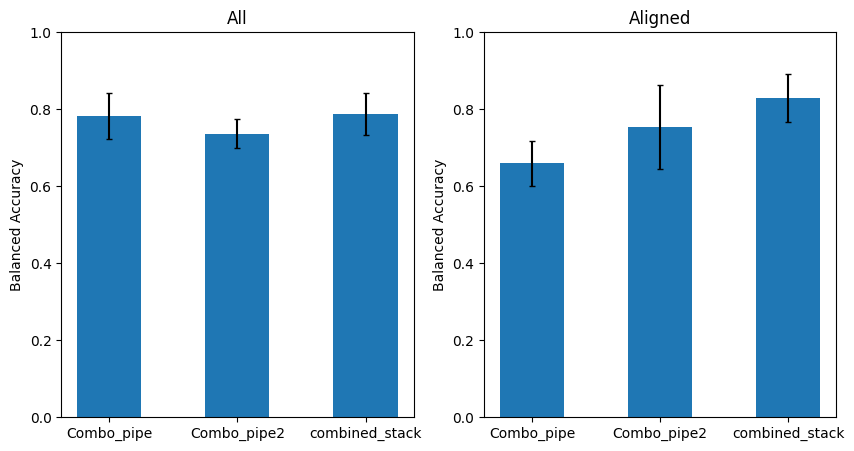

In [64]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(list(comboall_scores_all_ovr.keys()),[v['test_balanced_accuracy'].mean() for v in comboall_scores_all_ovr.values()],
        yerr=[v['test_balanced_accuracy'].std() for v in comboall_scores_all_ovr.values()],label='all',capsize=2,width=0.5)
plt.title('All')
plt.ylabel('Balanced Accuracy')
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.bar(list(comboall_scores_aligned_ovr.keys()),[v['test_balanced_accuracy'].mean() for v in comboall_scores_aligned_ovr.values()],
        yerr=[v['test_balanced_accuracy'].std() for v in comboall_scores_aligned_ovr.values()],label='aligned',capsize=2,width=0.5)
plt.title('Aligned')
plt.ylabel('Balanced Accuracy')
plt.ylim(0,1)

In [20]:
models = [Combo_pipe]
names = ['Combo_pipe']
scoring = ['balanced_accuracy','roc_auc_ovr']
needs_proba = [False,True]
supports_proba = [prob]

combo_scores_aligned_ovo =  test_models(models,names,supports_proba,aligned_dfs[sensor_columns],aligned_dfs['uid'], 'aligned dataset',scoring,needs_proba)
combo_scores_all_ovo = test_models(models,names,supports_proba,synced_dfs[sensor_columns],synced_dfs['uid'], 'complete dataset',scoring,needs_proba)

Testing models on aligned dataset


	[Combo_pipe: 18.129026 sec] - balanced_accuracy: 0.7554 (+/- 0.0547) - roc_auc_ovr: 0.9654 (+/- 0.0236)
Testing models on complete dataset
	[Combo_pipe: 220.437226 sec] - balanced_accuracy: 0.7603 (+/- 0.0451) - roc_auc_ovr: 0.9744 (+/- 0.0115)


# Blokk

In [18]:
from sklearn.decomposition import PCA

normed2 = StandardScaler().fit_transform(rows_all[0])

tsne = TSNE(n_components=2, random_state=42)
pca = PCA(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2) # todo use this for prediction as well

tsne_results2 = tsne.fit_transform(normed2)
pca_results2 = pca.fit_transform(normed2)
lda_results2 = lda.fit_transform(normed2, rows_all[1])

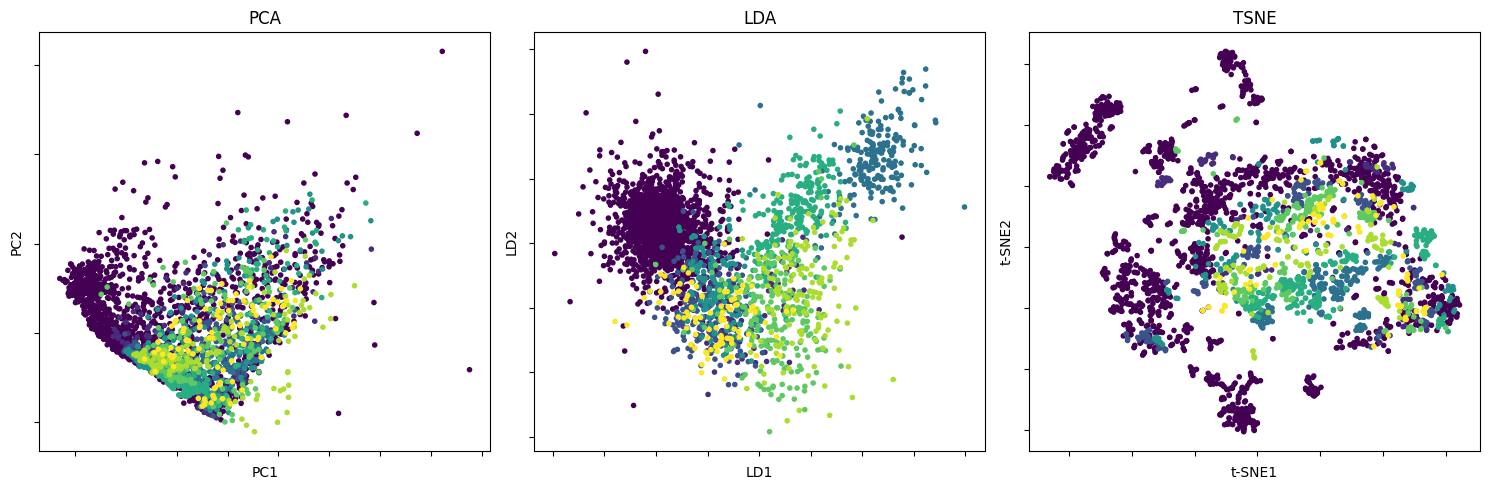

In [19]:
pca_results = pca_results2
tsne_results = tsne_results2
lda_results = lda_results2
cmp = rows_all[1]

fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
plt.scatter(pca_results[:,0], pca_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('PC1')
plt.gca().set_ylabel('PC2')
plt.title('PCA')


fig.add_subplot(132)
plt.scatter(lda_results[:,0], lda_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('LD1')
plt.gca().set_ylabel('LD2')
plt.title('LDA')

fig.add_subplot(133)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('t-SNE1')
plt.gca().set_ylabel('t-SNE2')
plt.title('TSNE')
plt.tight_layout()


#plt.scatter(tsne_results[:,0], tsne_results[:,1], c=rows_all[1],marker='.', cmap='viridis')

# ax = fig.add_subplot(projection='3d')
# ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=rows_all[1],marker='.', cmap='viridis')

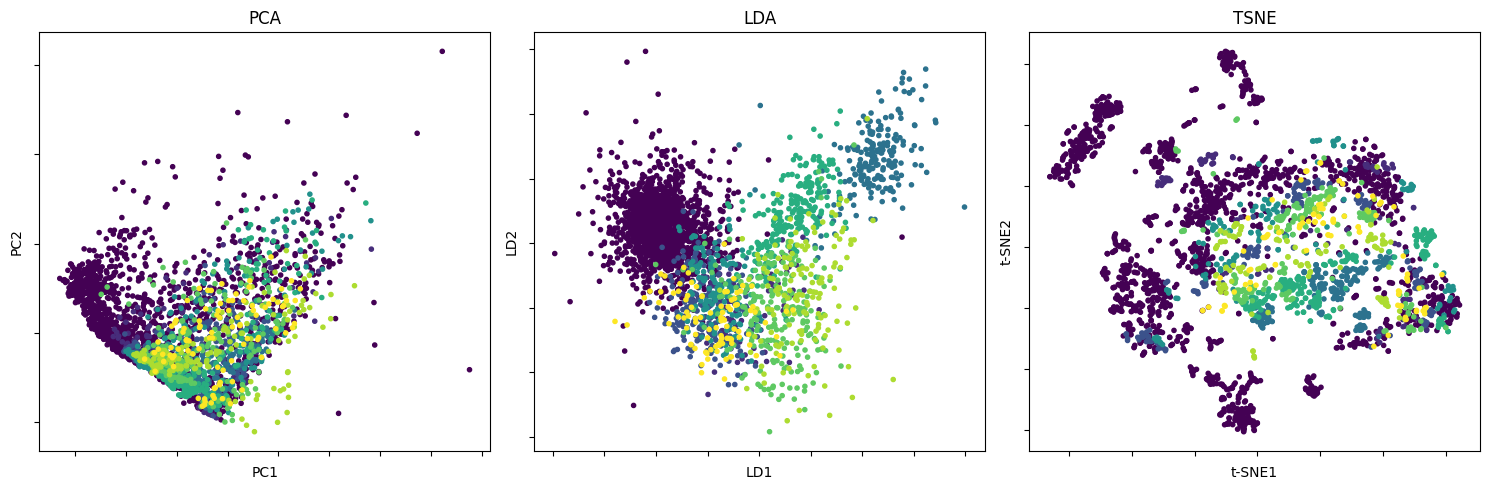

In [17]:
pca_results = pca_results0
tsne_results = tsne_results0
lda_results = lda_results0
cmp = rows_all[1]

fig = plt.figure(figsize=(15,5))
fig.add_subplot(131)
plt.scatter(pca_results[:,0], pca_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('PC1')
plt.gca().set_ylabel('PC2')
plt.title('PCA')


fig.add_subplot(132)
plt.scatter(lda_results[:,0], lda_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('LD1')
plt.gca().set_ylabel('LD2')
plt.title('LDA')

fig.add_subplot(133)
plt.scatter(tsne_results[:,0], tsne_results[:,1], c=cmp,marker='.', cmap='viridis')
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().set_xlabel('t-SNE1')
plt.gca().set_ylabel('t-SNE2')
plt.title('TSNE')
plt.tight_layout()


#plt.scatter(tsne_results[:,0], tsne_results[:,1], c=rows_all[1],marker='.', cmap='viridis')

# ax = fig.add_subplot(projection='3d')
# ax.scatter(tsne_results[:,0], tsne_results[:,1], tsne_results[:,2], c=rows_all[1],marker='.', cmap='viridis')

Each window has 3 sections, each containing 3 features for each dimension for each sensor (3\*3\*5 + 3\*5\*1 = 60 features/section)


/tmp/ipykernel_9008/3233282138.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_9008/3233282138.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


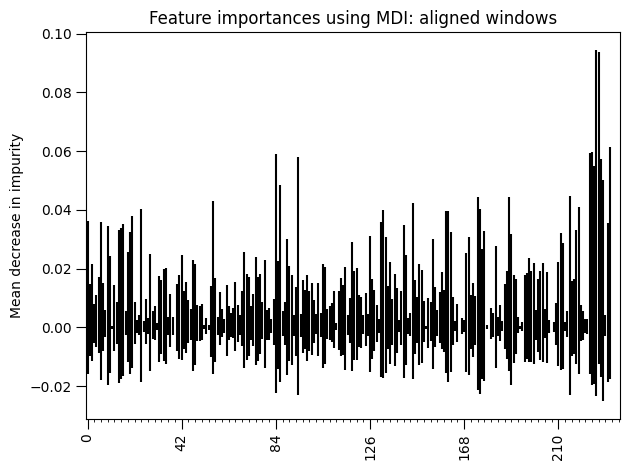

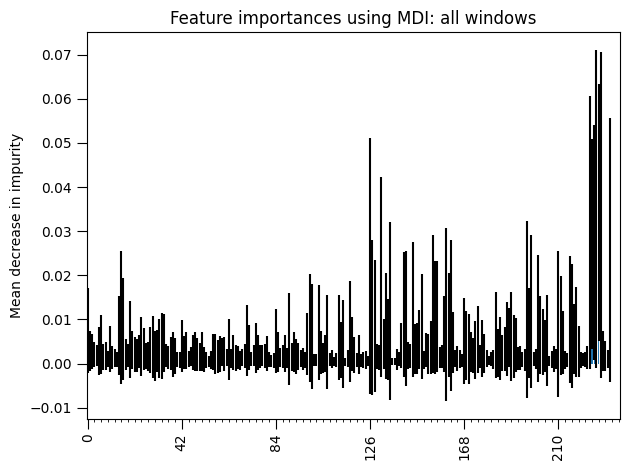

In [21]:
from matplotlib.ticker import MultipleLocator
from sklearn.decomposition import PCA

forest_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('model', RandomForestClassifier(n_estimators=50, random_state=42,class_weight='balanced'))
    ])
models = [forest_pipe]
names = ['Random Forest']
probs = [True]
#cvf =test_models(models,names,probs,*rows_aligned, 'aligned dataset')
#cvfa =test_models(models, names,probs, *rows_all, "all windows")

def forest_features_test(pipe, rows, name:str):
    pipe.fit(*rows)
    forest = pipe.named_steps['model']
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI: " + name)
    ax.set_ylabel("Mean decrease in impurity")

    ax.xaxis.set_minor_locator(MultipleLocator(3))
    ax.xaxis.set_major_locator(MultipleLocator(42))
    ax.tick_params(which='major', length=7)
    ax.xaxis.set_major_formatter('{x:.0f}')
    fig.tight_layout()
    fig.show()
    return importances

imp1 = forest_features_test(forest_pipe, rows_aligned, "aligned windows")
imp2 = forest_features_test(forest_pipe, rows_all, "all windows")

In [22]:
top_features = np.argsort(imp1)[::-1]
print("top feature names:")
tfn = [all_fnames[i] for i in top_features[:50]]
for sensor in sensor_names:
    ct = 0
    for fn in tfn:
        if sensor in fn:
            ct+=1
    print(f"{sensor}: {ct}")



top feature names:
ACC: 10
GYR: 3
GRV: 5
MAG: 11
ROT: 21


In [81]:
prob = True

""" 
pipe0 = Pipeline([
    ('sfe0', FunctionTransformer(create_features_sectioned_pipe, validate=False, kw_args={'selected_sections':[0]}))
    ,('scaler', StandardScaler())
    ,('model0', svm.SVC(class_weight='balanced',probability=prob,random_state=42))
])

pipe1 = Pipeline([
    ('sfe1',FunctionTransformer(create_features_sectioned_pipe, validate=False, kw_args={'selected_sections':[1]}))
    ,('scaler', StandardScaler())
    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))
])

pipe2 = Pipeline([
    ('sfe2', FunctionTransformer(create_features_sectioned_pipe, validate=False, kw_args={'selected_sections':[2]}))
    ,('scaler', StandardScaler())
    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))
]) 
pipe_full = Pipeline([
    ('sfe', FunctionTransformer(create_features_sectioned_pipe, validate=False, kw_args={'selected_sections':[0,1,2]}))
    ,('scaler', StandardScaler())
    ,('model_full', svm.SVC(class_weight='balanced',probability=prob,random_state=42))
    ])
"""

pipe0 = Pipeline([('selector', FunctionTransformer(sec0, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipe1 = Pipeline([('selector', FunctionTransformer(sec1, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model2', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipe2 = Pipeline([('selector', FunctionTransformer(sec2, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model3', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipe_full = Pipeline([('scaler', StandardScaler())
    ,('model_full', svm.SVC(class_weight='balanced',probability=prob,random_state=42))
    ]) 

estimators = [('pipe0', pipe0), ('pipe1', pipe1), ('pipe2', pipe2)]

eclf_voting_hard = VotingClassifier(estimators, voting='hard')
eclf_voting_soft = VotingClassifier(estimators, voting='soft')
Stacked_Lin = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=linear_model.LogisticRegression(class_weight='balanced',random_state=42))
Stacked_SVM = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=svm.SVC(class_weight='balanced',probability=prob,random_state=42))
models = [pipe0,pipe1,pipe2,pipe_full,eclf_voting_hard,eclf_voting_soft,Stacked_Lin,Stacked_SVM]

names = ['section 0','section 1','section 2','all sections','hard voting','soft voting','LogReg Stacked','SVM Stacked']
scoring = ['balanced_accuracy','roc_auc_ovo']
needs_proba = [False,True]
supports_proba = [prob,prob,prob,prob,False,False,True,True]


In [82]:
model_scores_aligned_ovo =  test_models(models,names,supports_proba,*rows_aligned, 'aligned dataset',scoring,needs_proba)
model_scores_all_ovo = test_models(models,names,supports_proba,*rows_all, 'complete dataset',scoring,needs_proba)

Testing models on aligned dataset
	[section 0: 0.077898 sec] - balanced_accuracy: 0.6868 (+/- 0.0542) - roc_auc_ovo: 0.9276 (+/- 0.0085)
	[section 1: 0.071455 sec] - balanced_accuracy: 0.7167 (+/- 0.0755) - roc_auc_ovo: 0.9273 (+/- 0.0370)
	[section 2: 0.042364 sec] - balanced_accuracy: 0.6962 (+/- 0.1189) - roc_auc_ovo: 0.9154 (+/- 0.0587)
	[all sections: 0.257027 sec] - balanced_accuracy: 0.8144 (+/- 0.0781) - roc_auc_ovo: 0.9602 (+/- 0.0250)
	[hard voting: 0.179500 sec] - balanced_accuracy: 0.7592 (+/- 0.0890)
	[soft voting: 0.146251 sec] - balanced_accuracy: 0.6219 (+/- 0.0786)
	[LogReg Stacked: 0.927386 sec] - balanced_accuracy: 0.7840 (+/- 0.0550) - roc_auc_ovo: 0.9499 (+/- 0.0271)
	[SVM Stacked: 1.104757 sec] - balanced_accuracy: 0.7668 (+/- 0.0560) - roc_auc_ovo: 0.9240 (+/- 0.0544)
Testing models on complete dataset
	[section 0: 7.525725 sec] - balanced_accuracy: 0.5951 (+/- 0.0371) - roc_auc_ovo: 0.9051 (+/- 0.0144)
	[section 1: 7.505690 sec] - balanced_accuracy: 0.6411 (+/- 

(0.0, 1.0)

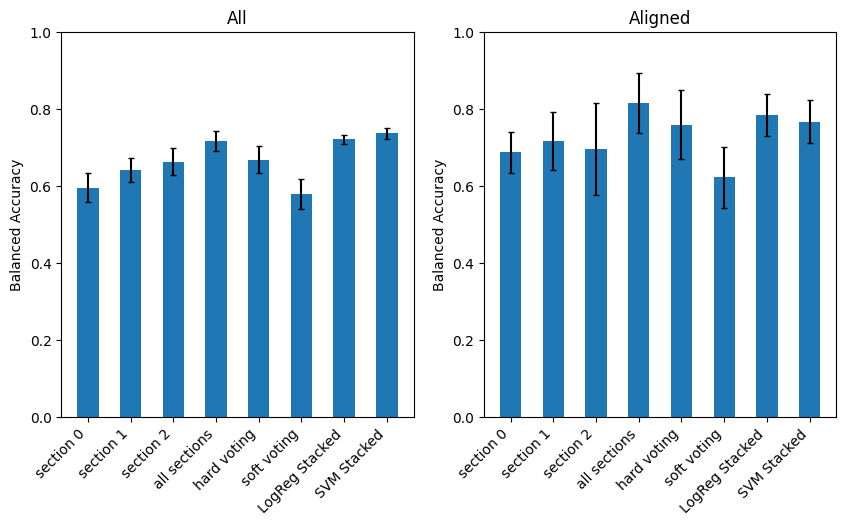

In [83]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(list(model_scores_all_ovo.keys()),[v['test_balanced_accuracy'].mean() for v in model_scores_all_ovo.values()],
        yerr=[v['test_balanced_accuracy'].std() for v in model_scores_all_ovo.values()],label='aligned',capsize=2,width=0.5)
plt.xticks(rotation=45, ha='right')

plt.title('All')
plt.ylabel('Balanced Accuracy')
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.bar(list(model_scores_aligned_ovo.keys()),[v['test_balanced_accuracy'].mean() for v in model_scores_aligned_ovo.values()],
        yerr=[v['test_balanced_accuracy'].std() for v in model_scores_aligned_ovo.values()],label='all',capsize=2,width=0.5)
plt.title('Aligned')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Balanced Accuracy')
plt.ylim(0,1)

In [84]:
prob = True
pipe0 = Pipeline([('selector', FunctionTransformer(sec0, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model0', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42),n_jobs=-1))])
pipe1 = Pipeline([('selector', FunctionTransformer(sec1, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42),n_jobs=-1))])
pipe2 = Pipeline([('selector', FunctionTransformer(sec2, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model2', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42),n_jobs=-1))])
pipe_full = Pipeline([('scaler', StandardScaler())
    ,('model_full', svm.SVC(class_weight='balanced',probability=prob,random_state=42))
    ]) 

estimators = [('pipe0', pipe0), ('pipe1', pipe1), ('pipe2', pipe2)]

eclf_voting_hard = VotingClassifier(estimators, voting='hard')
eclf_voting_soft = VotingClassifier(estimators, voting='soft')
Stacked_Lin = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=linear_model.LogisticRegression(class_weight='balanced',random_state=42))
Stacked_SVM = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=svm.SVC(class_weight='balanced',probability=prob,random_state=42))
models = [pipe0,pipe1,pipe2,pipe_full,eclf_voting_hard,eclf_voting_soft,Stacked_Lin,Stacked_SVM]
supports_proba = [prob,prob,prob,prob,False,False,True,True]
names = ['section 0','section 1','section 2','all sections','hard voting','soft voting','LogReg Stack','SVM Stack']
scoring = ['balanced_accuracy','roc_auc_ovr']
needs_proba = [False,True]

model_scores_aligned_ovr = test_models(models,names,supports_proba,*rows_aligned, 'aligned dataset',scoring,needs_proba)
model_scores_all_ovr = test_models(models,names,supports_proba,*rows_all, 'complete dataset',scoring,needs_proba)

Testing models on aligned dataset
	[section 0: 0.154443 sec] - balanced_accuracy: 0.7182 (+/- 0.0676) - roc_auc_ovr: 0.9453 (+/- 0.0110)
	[section 1: 0.117143 sec] - balanced_accuracy: 0.6714 (+/- 0.0541) - roc_auc_ovr: 0.9344 (+/- 0.0299)
	[section 2: 0.149515 sec] - balanced_accuracy: 0.7145 (+/- 0.1144) - roc_auc_ovr: 0.9216 (+/- 0.0640)
	[all sections: 0.064960 sec] - balanced_accuracy: 0.8144 (+/- 0.0781) - roc_auc_ovr: 0.9627 (+/- 0.0268)
	[hard voting: 0.382455 sec] - balanced_accuracy: 0.7461 (+/- 0.0853)
	[soft voting: 0.395303 sec] - balanced_accuracy: 0.6718 (+/- 0.0347)
	[LogReg Stack: 2.665504 sec] - balanced_accuracy: 0.7748 (+/- 0.0710) - roc_auc_ovr: 0.9476 (+/- 0.0309)
	[SVM Stack: 2.629137 sec] - balanced_accuracy: 0.7727 (+/- 0.0662) - roc_auc_ovr: 0.9322 (+/- 0.0505)
Testing models on complete dataset
	[section 0: 16.545390 sec] - balanced_accuracy: 0.6215 (+/- 0.0499) - roc_auc_ovr: 0.9335 (+/- 0.0137)
	[section 1: 16.227751 sec] - balanced_accuracy: 0.6684 (+/- 0.

(0.0, 1.0)

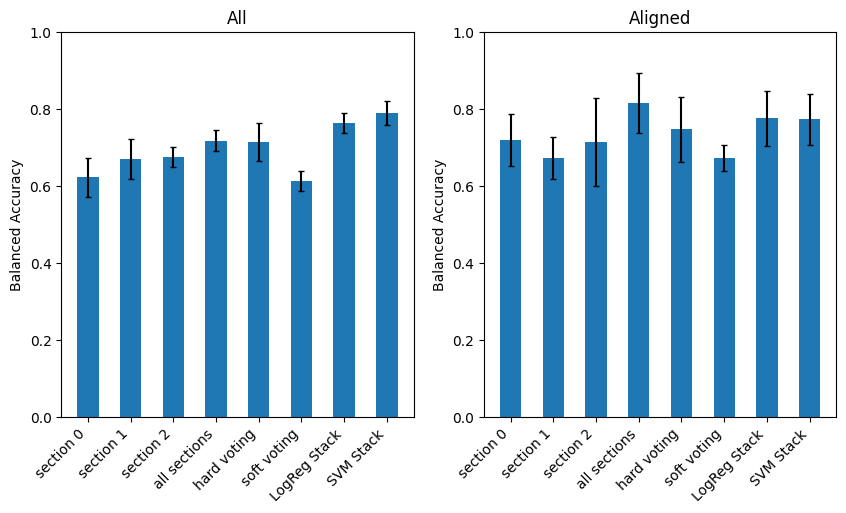

In [85]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(list(model_scores_all_ovr.keys()),[v['test_balanced_accuracy'].mean() for v in model_scores_all_ovr.values()],
        yerr=[v['test_balanced_accuracy'].std() for v in model_scores_all_ovr.values()],label='aligned',capsize=2,width=0.5)
plt.xticks(rotation=45, ha='right')

plt.title('All')
plt.ylabel('Balanced Accuracy')
plt.ylim(0,1)
plt.subplot(1,2,2)
plt.bar(list(model_scores_aligned_ovr.keys()),[v['test_balanced_accuracy'].mean() for v in model_scores_aligned_ovr.values()],
        yerr=[v['test_balanced_accuracy'].std() for v in model_scores_aligned_ovr.values()],label='all',capsize=2,width=0.5)
plt.title('Aligned')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Balanced Accuracy')
plt.ylim(0,1)

In [125]:
Stacked_Lin_copy = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=linear_model.LogisticRegression(class_weight='balanced',random_state=42))

In [23]:
Stacked_Lin = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=linear_model.LogisticRegression(class_weight='balanced',random_state=42))
Stacked_SVM = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=svm.SVC(class_weight='balanced',probability=prob,random_state=42))

models = [Stacked_Lin,Stacked_SVM]
names = ['Stacked_Lin','Stacked_SVM']
supports_proba = [prob,prob]

model_scores_aligned_stack = test_models(models,names,supports_proba,*rows_aligned, 'aligned dataset')
model_scores_all_stack = test_models(models,names,supports_proba,*rows_all, 'complete dataset')

Testing models on aligned dataset


	[Stacked_Lin: 4.747493 sec] - balanced_accuracy: 0.8401 (+/- 0.0759) - roc_auc_ovr: 0.9775 (+/- 0.0105)
	[Stacked_SVM: 5.708477 sec] - balanced_accuracy: 0.8418 (+/- 0.0649) - roc_auc_ovr: 0.9733 (+/- 0.0185)
Testing models on complete dataset


KeyboardInterrupt: 

In [28]:
prob = True
pipeACC = Pipeline([('selector', FunctionTransformer(sec(0,42), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipeGYR = Pipeline([('selector', FunctionTransformer(sec(42,84), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipeGRV = Pipeline([('selector', FunctionTransformer(sec(84,126), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipeMAG = Pipeline([('selector', FunctionTransformer(sec(126,168), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipeROT = Pipeline([('selector', FunctionTransformer(sec(168,238), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipe_full = Pipeline([('scaler', StandardScaler())
    ,('model_full', svm.SVC(class_weight='balanced',probability=prob,random_state=42))
    ]) 

estimators = [('pipeACC', pipeACC), ('pipeGYR', pipeGYR), ('pipeGRV', pipeGRV), ('pipeMAG', pipeMAG), ('pipeROT', pipeROT), ('pipe_full', pipe_full)]

eclf_voting_hard = VotingClassifier(estimators, voting='hard')
eclf_voting_soft = VotingClassifier(estimators, voting='soft')
models = [pipeACC,pipeGYR,pipeGRV,pipeMAG,pipeROT,pipe_full,eclf_voting_hard,eclf_voting_soft]
names = ['pipeACC','pipeGYR','pipeGRV','pipeMAG','pipeROT','pipe_full','eclf_voting_hard','eclf_voting_soft']
scoring = ['balanced_accuracy','roc_auc_ovo']
needs_proba = [False,True]
supports_proba = [prob,prob,prob,prob,prob,prob,False,False]

In [29]:
model_scores_aligned_ovo =  test_models(models,names,supports_proba,*rows_aligned, 'aligned dataset',scoring,needs_proba)
model_scores_all_ovo = test_models(models,names,supports_proba,*rows_all, 'complete dataset',scoring,needs_proba)

Testing models on aligned dataset
	[pipeACC: 0.042084 sec] - balanced_accuracy: 0.7130 (+/- 0.0601) - roc_auc_ovo: 0.9516 (+/- 0.0151)
	[pipeGYR: 0.037015 sec] - balanced_accuracy: 0.6774 (+/- 0.0837) - roc_auc_ovo: 0.9136 (+/- 0.0305)
	[pipeGRV: 0.044336 sec] - balanced_accuracy: 0.5501 (+/- 0.0458) - roc_auc_ovo: 0.8744 (+/- 0.0269)
	[pipeMAG: 0.042497 sec] - balanced_accuracy: 0.6880 (+/- 0.0754) - roc_auc_ovo: 0.9127 (+/- 0.0353)
	[pipeROT: 0.050603 sec] - balanced_accuracy: 0.6911 (+/- 0.0745) - roc_auc_ovo: 0.9381 (+/- 0.0300)
	[pipe_full: 0.076629 sec] - balanced_accuracy: 0.7592 (+/- 0.0880) - roc_auc_ovo: 0.9670 (+/- 0.0146)
	[eclf_voting_hard: 0.268000 sec] - balanced_accuracy: 0.7638 (+/- 0.0891)
	[eclf_voting_soft: 0.279165 sec] - balanced_accuracy: 0.6481 (+/- 0.0281)
Testing models on complete dataset
	[pipeACC: 6.678328 sec] - balanced_accuracy: 0.5735 (+/- 0.0406) - roc_auc_ovo: 0.8785 (+/- 0.0303)
	[pipeGYR: 9.293276 sec] - balanced_accuracy: 0.4237 (+/- 0.0341) - roc_

In [20]:
prob = True
pipeACC = Pipeline([('selector', FunctionTransformer(sec(0,42), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42)))])
pipeGYR = Pipeline([('selector', FunctionTransformer(sec(42,84), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42)))])
pipeGRV = Pipeline([('selector', FunctionTransformer(sec(84,126), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42)))])
pipeMAG = Pipeline([('selector', FunctionTransformer(sec(126,168), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42)))])
pipeROT = Pipeline([('selector', FunctionTransformer(sec(168,238), validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42)))])
pipe_full = Pipeline([('scaler', StandardScaler())
    ,('model_full', multiclass.OneVsRestClassifier(svm.SVC(class_weight='balanced',probability=prob,random_state=42)))
    ]) 

estimators = [('pipeACC', pipeACC), ('pipeGYR', pipeGYR), ('pipeGRV', pipeGRV), ('pipeMAG', pipeMAG), ('pipeROT', pipeROT), ('pipe_full', pipe_full)]

eclf_voting_hard = VotingClassifier(estimators, voting='hard')
eclf_voting_soft = VotingClassifier(estimators, voting='soft')
models = [pipeACC,pipeGYR,pipeGRV,pipeMAG,pipeROT,pipe_full,eclf_voting_hard,eclf_voting_soft]
names = ['pipeACC','pipeGYR','pipeGRV','pipeMAG','pipeROT','pipe_full','eclf_voting_hard','eclf_voting_soft']
scoring = ['balanced_accuracy','roc_auc_ovr']
needs_proba = [False,True]
supports_proba = [prob,prob,prob,prob,prob,prob,False,False]

In [65]:
model_scores_aligned_ovr =  test_models(models,names,supports_proba,*rows_aligned, 'aligned dataset',scoring,needs_proba)
model_scores_all_ovr = test_models(models,names,supports_proba,*rows_all, 'complete dataset',scoring,needs_proba)

Testing models on aligned dataset
	[pipeACC: 0.082447 sec] - balanced_accuracy: 0.7220 (+/- 0.0267) - roc_auc_ovr: 0.9568 (+/- 0.0150)
	[pipeGYR: 0.117932 sec] - balanced_accuracy: 0.6174 (+/- 0.0902) - roc_auc_ovr: 0.9310 (+/- 0.0215)
	[pipeGRV: 0.088726 sec] - balanced_accuracy: 0.5743 (+/- 0.0474) - roc_auc_ovr: 0.8888 (+/- 0.0197)
	[pipeMAG: 0.092734 sec] - balanced_accuracy: 0.6611 (+/- 0.0679) - roc_auc_ovr: 0.9156 (+/- 0.0371)
	[pipeROT: 0.082868 sec] - balanced_accuracy: 0.6663 (+/- 0.0384) - roc_auc_ovr: 0.9333 (+/- 0.0418)
	[pipe_full: 0.175274 sec] - balanced_accuracy: 0.7553 (+/- 0.0700) - roc_auc_ovr: 0.9822 (+/- 0.0102)
	[eclf_voting_hard: 0.592752 sec] - balanced_accuracy: 0.7330 (+/- 0.0548)
	[eclf_voting_soft: 0.610085 sec] - balanced_accuracy: 0.6944 (+/- 0.0562)
Testing models on complete dataset
	[pipeACC: 15.198983 sec] - balanced_accuracy: 0.5759 (+/- 0.0449) - roc_auc_ovr: 0.9091 (+/- 0.0240)
	[pipeGYR: 21.580575 sec] - balanced_accuracy: 0.4232 (+/- 0.0366) - ro

In [21]:
Stacked_Lin = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=linear_model.LogisticRegression(class_weight='balanced',random_state=42))
Stacked_SVM = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=svm.SVC(class_weight='balanced',probability=prob,random_state=42))

models = [Stacked_Lin,Stacked_SVM]
names = ['Stacked_Lin','Stacked_SVM']
supports_proba = [prob,prob]

model_scores_aligned_stack = test_models(models,names,supports_proba,*rows_aligned, 'aligned dataset')
model_scores_all_stack = test_models(models,names,supports_proba,*rows_all, 'complete dataset')

NameError: name 'test_models' is not defined

/tmp/ipykernel_9008/3423219062.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(nms,rotation=45, ha='right')
/tmp/ipykernel_9008/3423219062.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(nms,rotation=45, ha='right')


Text(0.5, 1.0, 'Complete dataset')

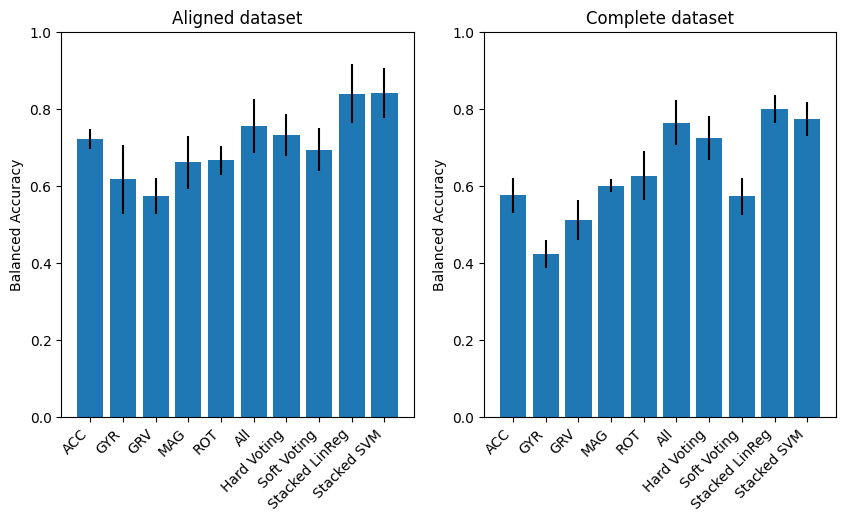

In [75]:
plt.figure(figsize=(10,5))
plt.tight_layout()
plt.subplot(1,2,1)
nms=['ACC','GYR','GRV','MAG','ROT','All','Hard Voting','Soft Voting','Stacked LinReg','Stacked SVM']
plt.bar(nms,[model_scores_aligned_ovr['pipeACC']['test_balanced_accuracy'].mean(),
             model_scores_aligned_ovr['pipeGYR']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovr['pipeGRV']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovr['pipeMAG']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovr['pipeROT']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovr['pipe_full']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovr['eclf_voting_hard']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovr['eclf_voting_soft']['test_balanced_accuracy'].mean(),
                model_scores_aligned_stack['Stacked_Lin']['test_balanced_accuracy'].mean(),
                model_scores_aligned_stack['Stacked_SVM']['test_balanced_accuracy'].mean()],
        
        yerr=[model_scores_aligned_ovr['pipeACC']['test_balanced_accuracy'].std(),
                model_scores_aligned_ovr['pipeGYR']['test_balanced_accuracy'].std(),
                    model_scores_aligned_ovr['pipeGRV']['test_balanced_accuracy'].std(),
                    model_scores_aligned_ovr['pipeMAG']['test_balanced_accuracy'].std(),
                    model_scores_aligned_ovr['pipeROT']['test_balanced_accuracy'].std(),
                    model_scores_aligned_ovr['pipe_full']['test_balanced_accuracy'].std(),
                    model_scores_aligned_ovr['eclf_voting_hard']['test_balanced_accuracy'].std(),
                    model_scores_aligned_ovr['eclf_voting_soft']['test_balanced_accuracy'].std(),
                    model_scores_aligned_stack['Stacked_Lin']['test_balanced_accuracy'].std(),
                model_scores_aligned_stack['Stacked_SVM']['test_balanced_accuracy'].std()])
plt.ylabel('Balanced Accuracy')
plt.gca().set_ylim(0,1)
plt.gca().set_xticklabels(nms,rotation=45, ha='right')

plt.title('Aligned dataset')
plt.subplot(1,2,2)
plt.bar(nms,[model_scores_all_ovr['pipeACC']['test_balanced_accuracy'].mean(),
             model_scores_all_ovr['pipeGYR']['test_balanced_accuracy'].mean(),
                model_scores_all_ovr['pipeGRV']['test_balanced_accuracy'].mean(),
                model_scores_all_ovr['pipeMAG']['test_balanced_accuracy'].mean(),
                model_scores_all_ovr['pipeROT']['test_balanced_accuracy'].mean(),
                model_scores_all_ovr['pipe_full']['test_balanced_accuracy'].mean(),
                model_scores_all_ovr['eclf_voting_hard']['test_balanced_accuracy'].mean(),
                model_scores_all_ovr['eclf_voting_soft']['test_balanced_accuracy'].mean(),
                model_scores_all_stack['Stacked_Lin']['test_balanced_accuracy'].mean(),
                model_scores_all_stack['Stacked_SVM']['test_balanced_accuracy'].mean()],
        yerr=[model_scores_all_ovr['pipeACC']['test_balanced_accuracy'].std(),
                model_scores_all_ovr['pipeGYR']['test_balanced_accuracy'].std(),
                    model_scores_all_ovr['pipeGRV']['test_balanced_accuracy'].std(),
                    model_scores_all_ovr['pipeMAG']['test_balanced_accuracy'].std(),
                    model_scores_all_ovr['pipeROT']['test_balanced_accuracy'].std(),
                    model_scores_all_ovr['pipe_full']['test_balanced_accuracy'].std(),
                    model_scores_all_ovr['eclf_voting_hard']['test_balanced_accuracy'].std(),
                    model_scores_all_ovr['eclf_voting_soft']['test_balanced_accuracy'].std(),
                    model_scores_all_stack['Stacked_Lin']['test_balanced_accuracy'].std(),
                model_scores_all_stack['Stacked_SVM']['test_balanced_accuracy'].std()])
plt.ylabel('Balanced Accuracy')
plt.gca().set_ylim(0,1)
plt.gca().set_xticklabels(nms,rotation=45, ha='right')
plt.title('Complete dataset')





/tmp/ipykernel_9008/4233492644.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(nms,rotation=45)
/tmp/ipykernel_9008/4233492644.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(nms,rotation=45)


Text(0.5, 1.0, 'Complete dataset')

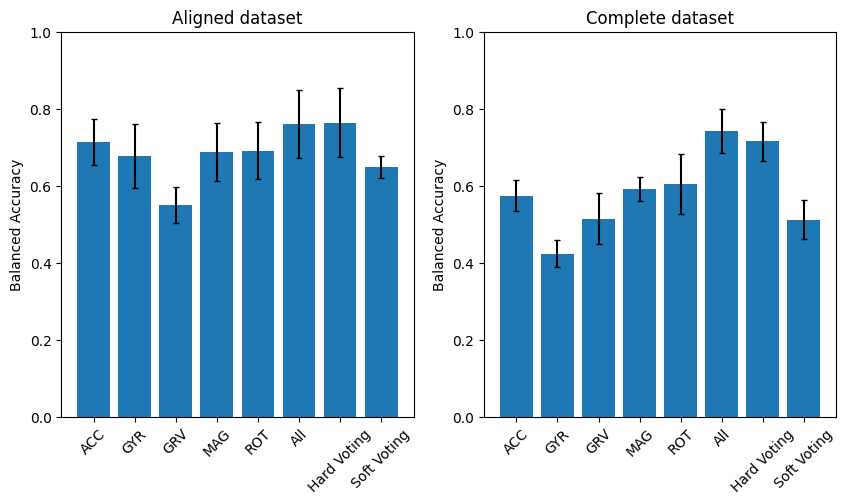

In [63]:
plt.figure(figsize=(10,5))
plt.tight_layout()
plt.subplot(1,2,1)
nms=['ACC','GYR','GRV','MAG','ROT','All','Hard Voting','Soft Voting']
plt.bar(nms, [model_scores_aligned_ovo['pipeACC']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovo['pipeGYR']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovo['pipeGRV']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovo['pipeMAG']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovo['pipeROT']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovo['pipe_full']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovo['eclf_voting_hard']['test_balanced_accuracy'].mean(),
                model_scores_aligned_ovo['eclf_voting_soft']['test_balanced_accuracy'].mean()], 
        yerr=[model_scores_aligned_ovo['pipeACC']['test_balanced_accuracy'].std(),
                model_scores_aligned_ovo['pipeGYR']['test_balanced_accuracy'].std(),
                model_scores_aligned_ovo['pipeGRV']['test_balanced_accuracy'].std(),
                model_scores_aligned_ovo['pipeMAG']['test_balanced_accuracy'].std(),
                model_scores_aligned_ovo['pipeROT']['test_balanced_accuracy'].std(),
                model_scores_aligned_ovo['pipe_full']['test_balanced_accuracy'].std(),
                model_scores_aligned_ovo['eclf_voting_hard']['test_balanced_accuracy'].std(),
                model_scores_aligned_ovo['eclf_voting_soft']['test_balanced_accuracy'].std()],align='center', alpha=1, ecolor='black', capsize=2)
plt.ylabel('Balanced Accuracy')
plt.gca().set_ylim(0,1)
plt.gca().set_xticklabels(nms,rotation=45)
plt.title('Aligned dataset')

plt.subplot(1,2,2)
plt.bar(nms, [model_scores_all_ovo['pipeACC']['test_balanced_accuracy'].mean(),
                model_scores_all_ovo['pipeGYR']['test_balanced_accuracy'].mean(),
                model_scores_all_ovo['pipeGRV']['test_balanced_accuracy'].mean(),
                model_scores_all_ovo['pipeMAG']['test_balanced_accuracy'].mean(),
                model_scores_all_ovo['pipeROT']['test_balanced_accuracy'].mean(),
                model_scores_all_ovo['pipe_full']['test_balanced_accuracy'].mean(),
                model_scores_all_ovo['eclf_voting_hard']['test_balanced_accuracy'].mean(),
                model_scores_all_ovo['eclf_voting_soft']['test_balanced_accuracy'].mean()], 
        yerr=[model_scores_all_ovo['pipeACC']['test_balanced_accuracy'].std(),
                model_scores_all_ovo['pipeGYR']['test_balanced_accuracy'].std(),
                model_scores_all_ovo['pipeGRV']['test_balanced_accuracy'].std(),
                model_scores_all_ovo['pipeMAG']['test_balanced_accuracy'].std(),
                model_scores_all_ovo['pipeROT']['test_balanced_accuracy'].std(),
                model_scores_all_ovo['pipe_full']['test_balanced_accuracy'].std(),
                model_scores_all_ovo['eclf_voting_hard']['test_balanced_accuracy'].std(),
                model_scores_all_ovo['eclf_voting_soft']['test_balanced_accuracy'].std()],align='center', alpha=1, ecolor='black', capsize=2)
plt.ylabel('Balanced Accuracy')
plt.gca().set_ylim(0,1)
plt.gca().set_xticklabels(nms,rotation=45)
plt.title('Complete dataset')




In [127]:
x_train, x_test, y_train, y_test = train_test_split(*rows_aligned, test_size=0.3, random_state=42)
stl_aligned = Stacked_Lin_copy.fit(x_train, y_train)
print(classification_report(y_test, stl_aligned.predict(x_test)))

x_train, x_test, y_train, y_test = train_test_split(*rows_all, test_size=0.3, random_state=42)
stl_all = Stacked_Lin.fit(x_train, y_train)
print(classification_report(y_test, stl_all.predict(x_test)))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97        31
           1       0.50      0.40      0.44         5
           2       1.00      1.00      1.00         6
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      1.00      1.00         5
           6       0.86      0.86      0.86         7
           7       1.00      1.00      1.00         5
           8       0.75      1.00      0.86         3

    accuracy                           0.93        72
   macro avg       0.90      0.91      0.90        72
weighted avg       0.93      0.93      0.93        72

              precision    recall  f1-score   support

           0       0.98      0.90      0.94       562
           1       0.68      0.88      0.77        26
           2       0.93      0.96      0.95        55
           3       0.95      0.98      0.97        58
           4       0.62 

In [128]:
from sklearn.metrics import balanced_accuracy_score
x_train, x_test, y_train, y_test = train_test_split(*rows_all, test_size=0.3, random_state=42)
y_pred_all = stl_all.predict(x_test)
conf_mat_all = confusion_matrix(y_test, y_pred_all)
print(conf_mat_all)


[[506   9   3   2  21   2   3   1  15]
 [  1  23   0   0   0   0   1   1   0]
 [  1   0  53   0   0   0   0   1   0]
 [  0   0   0  57   0   1   0   0   0]
 [  4   0   1   0  36   0   1   0   0]
 [  0   0   0   0   0  62   1   0   0]
 [  2   2   0   1   0   1  52   1   2]
 [  1   0   0   0   0   0   2  52   2]
 [  3   0   0   0   1   0   0   0  24]]


In [129]:
x_train, x_test, y_train, y_test = train_test_split(*rows_aligned, test_size=0.3, random_state=42)
y_pred_al_from_all = stl_all.predict(x_test)
conf_mat_al_from_all= confusion_matrix(y_test, y_pred_al_from_all)
print(conf_mat_al_from_all)


[[30  0  0  0  1  0  0  0  0]
 [ 0  5  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0]
 [ 3  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0]
 [ 1  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  3]]


In [130]:
x_train, x_test, y_train, y_test = train_test_split(*rows_aligned, test_size=0.3, random_state=42)

y_pred_al = stl_aligned.predict(x_test)
conf_mat_al = confusion_matrix(y_test, y_pred_al)
print(conf_mat_al)

[[30  1  0  0  0  0  0  0  0]
 [ 1  2  0  0  0  0  1  0  1]
 [ 0  0  6  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0]
 [ 0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0]
 [ 0  1  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0  0  0  0  0  3]]


In [131]:
x_train, x_test, y_train, y_test = train_test_split(*rows_all, test_size=0.3, random_state=42)

y_pred__all_from_al = stl_aligned.predict(x_test)
conf_mat__all_from_al = confusion_matrix(y_test, y_pred__all_from_al)
print(conf_mat__all_from_al)

[[547   9   0   1   1   0   0   0   4]
 [ 16   6   0   0   0   0   4   0   0]
 [ 27   4  19   0   0   0   4   1   0]
 [ 19  10   0  15   0   1   0   0  13]
 [ 25   3   0   0  14   0   0   0   0]
 [ 30   4   3   0   0  12  11   0   3]
 [ 38   6   0   0   2   0  15   0   0]
 [ 20  13   0   0   0   0   3  19   2]
 [ 18   0   0   0   0   0   4   0   6]]


[Text(0, 0.5, '0002 (113)'),
 Text(0, 1.5, '90001 (12)'),
 Text(0, 2.5, '90002 (19)'),
 Text(0, 3.5, '90003 (17)'),
 Text(0, 4.5, '90004 (15)'),
 Text(0, 5.5, '90005 (17)'),
 Text(0, 6.5, '90006 (20)'),
 Text(0, 7.5, '90007 (15)'),
 Text(0, 8.5, '90010 (11)')]

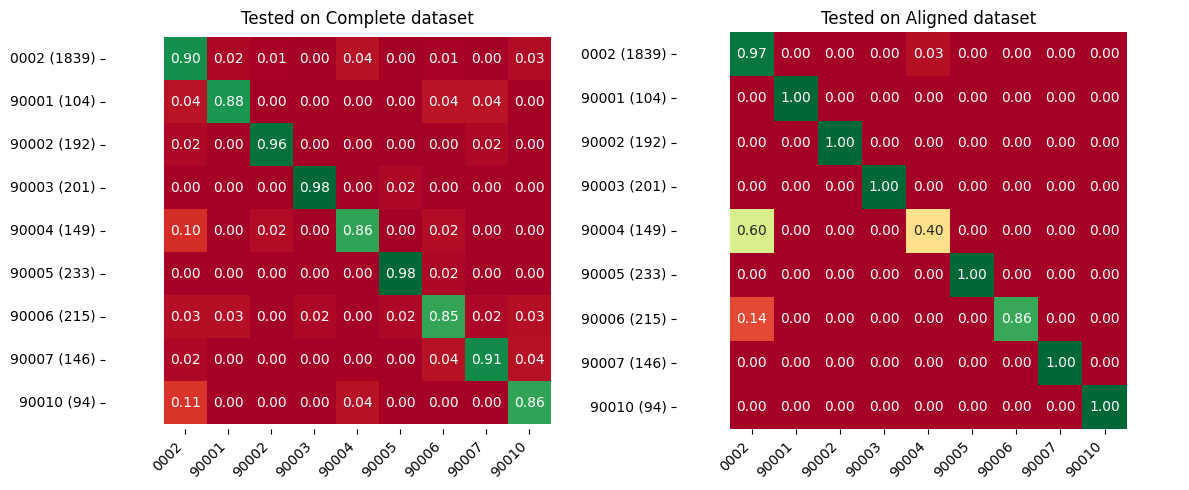

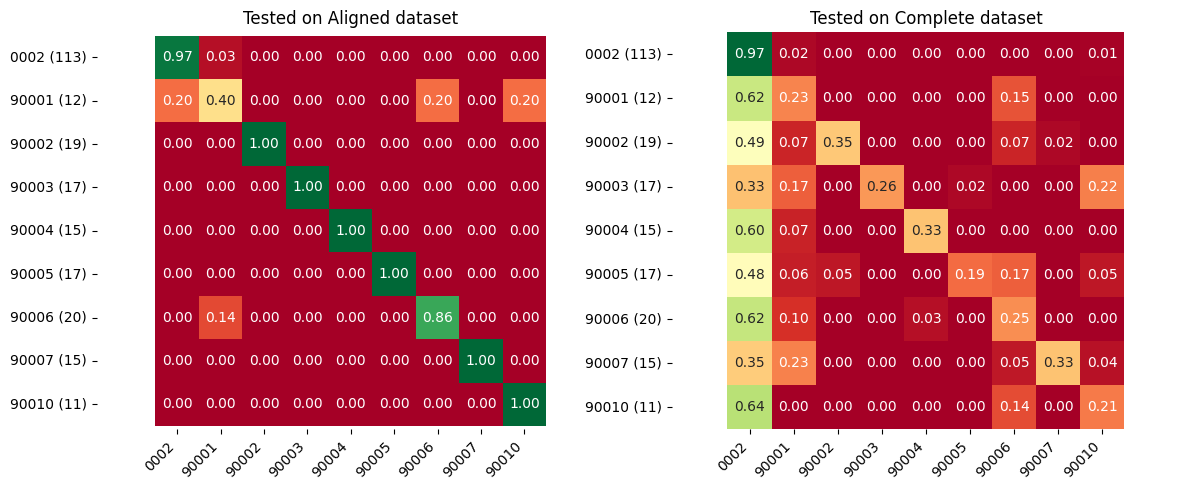

In [153]:


class_names_all = le1.classes_
samples_per_class_all = [np.sum(np.array(rows_all[1]) == i) for i in np.unique(rows_all[1])]
class_labels_all = [f'{class_names_all[i]} ({samples_per_class_all[i]})' for i in range(len(class_names_all))]

class_names_al = le2.classes_
samples_per_class_al = [np.sum(np.array(rows_aligned[1]) == i) for i in np.unique(rows_all[1])]
class_labels_al = [f'{class_names_al[i]} ({samples_per_class_al[i]})' for i in range(len(class_names_al))]

n_conf_mat_all = conf_mat_all.astype('float') / conf_mat_all.sum(axis=1)[:, np.newaxis]
n_conf_mat_al_from_all = conf_mat_al_from_all.astype('float') / conf_mat_al_from_all.sum(axis=1)[:, np.newaxis]
n_conf_mat_al = conf_mat_al.astype('float') / conf_mat_al.sum(axis=1)[:, np.newaxis]
n_conf_mat__all_from_al = conf_mat__all_from_al.astype('float') / conf_mat__all_from_al.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Tested on Complete dataset')
plt.axis('equal')
plt.tight_layout()
sns.heatmap(n_conf_mat_all, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, xticklabels=class_labels_all, yticklabels=class_labels_all)
plt.gca().set_xticklabels(class_names_all,rotation=45, ha='right')

plt.subplot(1,2,2)
plt.title('Tested on Aligned dataset')
plt.axis('equal')
plt.tight_layout()
sns.heatmap(n_conf_mat_al_from_all, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, xticklabels=class_labels_all, yticklabels=class_labels_all)
plt.gca().set_xticklabels(class_names_all,rotation=45, ha='right')



########

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.title('Tested on Aligned dataset')
plt.axis('equal')
plt.tight_layout()
sns.heatmap(n_conf_mat_al, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, xticklabels=class_labels_al, yticklabels=class_labels_al)
plt.gca().set_xticklabels(class_names_al,rotation=45, ha='right')

plt.subplot(1,2,2)
plt.title('Tested on Complete dataset')
plt.axis('equal')
plt.tight_layout()
sns.heatmap(n_conf_mat__all_from_al, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, xticklabels=class_labels_al, yticklabels=class_labels_al)
plt.gca().set_xticklabels(class_names_al,rotation=45, ha='right')



[Text(0.5, 0, '0002 (1839)'),
 Text(1.5, 0, '90001 (104)'),
 Text(2.5, 0, '90002 (192)'),
 Text(3.5, 0, '90003 (201)'),
 Text(4.5, 0, '90004 (149)'),
 Text(5.5, 0, '90005 (233)'),
 Text(6.5, 0, '90006 (215)'),
 Text(7.5, 0, '90007 (146)'),
 Text(8.5, 0, '90010 (94)')]

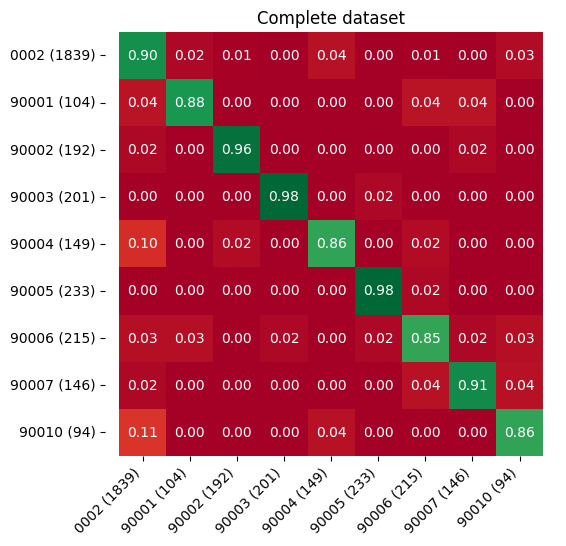

In [135]:
class_names = le1.classes_
conf_mat_ = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
samples_per_class = [np.sum(np.array(rows_all[1]) == i) for i in np.unique(rows_all[1])]
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Complete dataset')
plt.axis('equal')
plt.tight_layout()
class_labels = [f'{class_names[i]} ({samples_per_class[i]})' for i in range(len(class_names))]
sns.heatmap(conf_mat_, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, yticklabels=class_labels)
plt.gca().set_xticklabels(class_labels,rotation=45, ha='right')


<Axes: title={'center': 'Aligned windows'}>

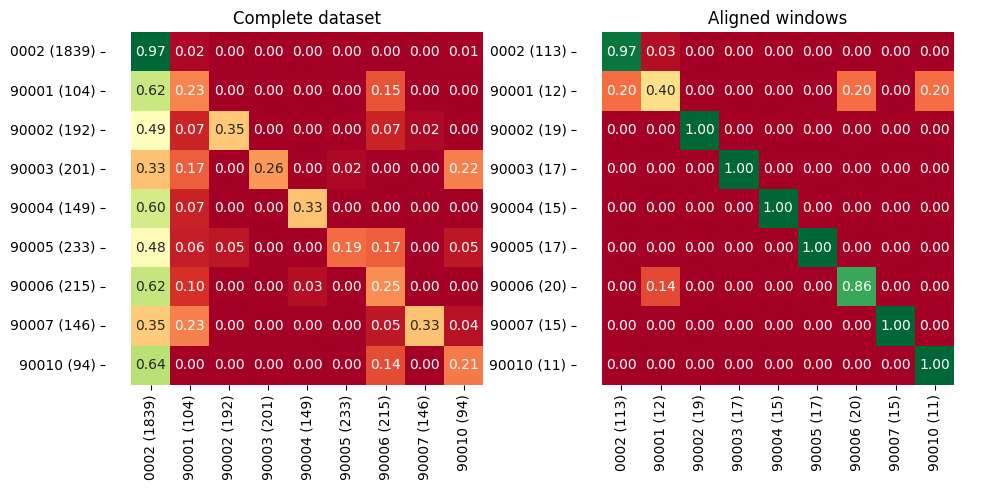

In [94]:
x_train, x_test, y_train, y_test = train_test_split(*rows_all, test_size=0.3, random_state=42)
y_pred_all = stl_all.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred_all)
class_names = le1.classes_
conf_mat_ = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
samples_per_class = [np.sum(np.array(rows_all[1]) == i) for i in np.unique(rows_all[1])]

# Create labels with class names and number of samples
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Complete dataset')
plt.axis('equal')
plt.tight_layout()
class_labels = [f'{class_names[i]} ({samples_per_class[i]})' for i in range(len(class_names))]
sns.heatmap(conf_mat_, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, xticklabels=class_labels, yticklabels=class_labels)

x_train, x_test, y_train, y_test = train_test_split(*rows_aligned, test_size=0.3, random_state=42)
y_pred = stl_aligned.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
class_names = le2.classes_
conf_mat_ = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
samples_per_class = [np.sum(np.array(rows_aligned[1]) == i) for i in np.unique(rows_aligned[1])]
plt.subplot(1,2,2)
plt.title("Aligned windows")
plt.axis('equal')
plt.tight_layout()
class_labels = [f'{class_names[i]} ({samples_per_class[i]})' for i in range(len(class_names))]
sns.heatmap(conf_mat_, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, xticklabels=class_labels, yticklabels=class_labels)

<Axes: >

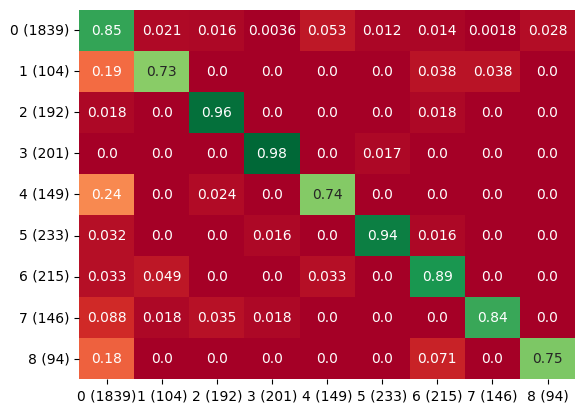

In [24]:
x_train, x_test, y_train, y_test = train_test_split(*rows_all, test_size=0.3, random_state=42)
pipe_full.fit(x_train, y_train)
y_pred = pipe_full.predict(x_test)
y_pred_prob = pipe_full.predict_proba(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
class_names = le1.classes_
conf_mat_ = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
samples_per_class = [np.sum(np.array(rows_all[1]) == i) for i in np.unique(rows_all[1])]

# Create labels with class names and number of samples
class_labels = [f'{class_names[i]} ({samples_per_class[i]})' for i in range(len(class_names))]
sns.heatmap(conf_mat_, annot=True, fmt='.2',cmap='RdYlGn', cbar=False, xticklabels=class_labels, yticklabels=class_labels)


<Axes: title={'center': 'Aligned windows'}>

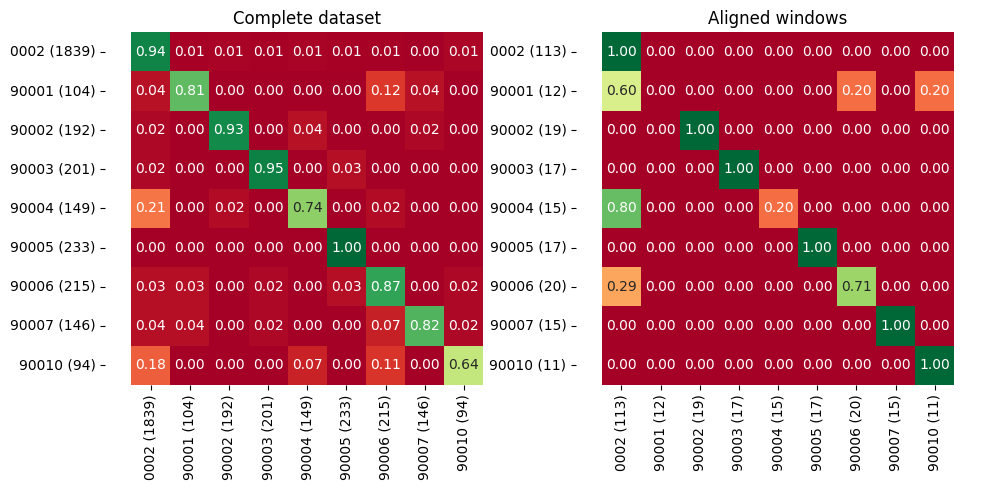

In [81]:
x_train, x_test, y_train, y_test = train_test_split(*rows_all, test_size=0.3, random_state=42)
pipe_full.fit(x_train, y_train)
y_pred = pipe_full.predict(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
class_names = le1.classes_
conf_mat_ = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
samples_per_class = [np.sum(np.array(rows_all[1]) == i) for i in np.unique(rows_all[1])]

# Create labels with class names and number of samples
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Complete dataset')
plt.axis('equal')
plt.tight_layout()
class_labels = [f'{class_names[i]} ({samples_per_class[i]})' for i in range(len(class_names))]
sns.heatmap(conf_mat_, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, xticklabels=class_labels, yticklabels=class_labels)

x_train, x_test, y_train, y_test = train_test_split(*rows_aligned, test_size=0.3, random_state=42)
pipe_full.fit(x_train, y_train)
y_pred = pipe_full.predict(x_test)
y_pred_prob = pipe_full.predict_proba(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
class_names = le2.classes_
conf_mat_ = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
samples_per_class = [np.sum(np.array(rows_aligned[1]) == i) for i in np.unique(rows_aligned[1])]
plt.subplot(1,2,2)
plt.title("Aligned windows")
plt.axis('equal')
plt.tight_layout()
class_labels = [f'{class_names[i]} ({samples_per_class[i]})' for i in range(len(class_names))]
sns.heatmap(conf_mat_, annot=True, fmt='.2f',cmap='RdYlGn', cbar=False, xticklabels=class_labels, yticklabels=class_labels)



<Axes: >

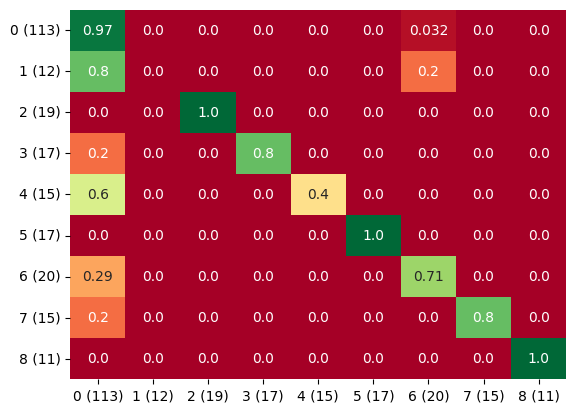

In [25]:
x_train, x_test, y_train, y_test = train_test_split(*rows_aligned, test_size=0.3, random_state=42)
pipe_full.fit(x_train, y_train)
y_pred = pipe_full.predict(x_test)
y_pred_prob = pipe_full.predict_proba(x_test)
conf_mat = confusion_matrix(y_test, y_pred)
class_names = le2.classes_
conf_mat_ = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
samples_per_class = [np.sum(np.array(rows_aligned[1]) == i) for i in np.unique(rows_aligned[1])]
# Create labels with class names and number of samples
class_labels = [f'{class_names[i]} ({samples_per_class[i]})' for i in range(len(class_names))]
sns.heatmap(conf_mat_, annot=True, fmt='.2',cmap='RdYlGn', cbar=False, xticklabels=class_labels, yticklabels=class_labels)



# 1 vs rest

In [132]:


pipe0 = Pipeline([('selector', FunctionTransformer(sec0, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model0', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipe1 = Pipeline([('selector', FunctionTransformer(sec1, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model1', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipe2 = Pipeline([('selector', FunctionTransformer(sec2, validate=False))
                    ,('scaler', StandardScaler())
                    ,('model2', svm.SVC(class_weight='balanced',probability=prob,random_state=42))])
pipe_full = Pipeline([('scaler', StandardScaler())
    ,('model_full', svm.SVC(class_weight='balanced',probability=prob,random_state=42))
    ]) 

estimators = [('pipe0', pipe0), ('pipe1', pipe1), ('pipe2', pipe2)]

eclf_voting_hard = VotingClassifier(estimators, voting='hard')
eclf_voting_soft = VotingClassifier(estimators, voting='soft')
Stacked_Lin = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=linear_model.LogisticRegression(class_weight='balanced',random_state=42))
Stacked_SVM = ensemble.StackingClassifier(estimators=estimators, 
                                          final_estimator=svm.SVC(class_weight='balanced',probability=prob,random_state=42))

models = [pipe0,pipe1,pipe2,pipe_full,eclf_voting_hard,eclf_voting_soft,Stacked_Lin,Stacked_SVM]
names = ['pipe0','pipe1','pipe2','pipe_full','eclf_voting_hard','eclf_voting_soft','Stacked_Lin','Stacked_SVM']




(3058, 180)
(227, 180)


In [138]:
for selected_id in le1.transform(le1.classes_):
    print("Selected ID:",le1.inverse_transform([selected_id]))
    local_labels = rows_all[1].copy()
    local_labels[local_labels != selected_id] = -1
    local_labels = LabelEncoder().fit_transform(local_labels)
    
    local_a_labels = rows_aligned[1].copy()
    local_a_labels[local_a_labels != selected_id] = -1
    local_a_labels = LabelEncoder().fit_transform(local_a_labels)
    
    print("aligned:",*np.unique(local_a_labels, return_counts=True))
    print("all:",*np.unique(local_labels, return_counts=True))
  

    test_models(models,names, rows_aligned[0],local_a_labels, 'aligned dataset')
    test_models(models,names, rows_all[0], local_labels, 'complete dataset')
    
    
    

Selected ID: ['0002']
all: [0 1] [1181 1877]
aligned: [0 1] [109 118]
Testing models on complete dataset
	 [pipe0] 	 Balanced Accuracy: 0.81 (+/- 0.09)
	 [pipe1] 	 Balanced Accuracy: 0.82 (+/- 0.09)
	 [pipe2] 	 Balanced Accuracy: 0.85 (+/- 0.08)
	 [pipe_full] 	 Balanced Accuracy: 0.85 (+/- 0.07)
	 [eclf_voting_hard] 	 Balanced Accuracy: 0.84 (+/- 0.09)
	 [eclf_voting_soft] 	 Balanced Accuracy: 0.83 (+/- 0.09)
Testing models on aligned dataset
	 [pipe0] 	 Balanced Accuracy: 0.67 (+/- 0.12)
	 [pipe1] 	 Balanced Accuracy: 0.72 (+/- 0.14)
	 [pipe2] 	 Balanced Accuracy: 0.78 (+/- 0.10)
	 [pipe_full] 	 Balanced Accuracy: 0.80 (+/- 0.11)
	 [eclf_voting_hard] 	 Balanced Accuracy: 0.76 (+/- 0.10)
	 [eclf_voting_soft] 	 Balanced Accuracy: 0.76 (+/- 0.11)
Selected ID: ['90001']
all: [0 1] [2986   72]
aligned: [0 1] [219   8]
Testing models on complete dataset
	 [pipe0] 	 Balanced Accuracy: 0.83 (+/- 0.06)
	 [pipe1] 	 Balanced Accuracy: 0.85 (+/- 0.08)
	 [pipe2] 	 Balanced Accuracy: 0.86 (+/- 0.09

pd.qcut() ? 

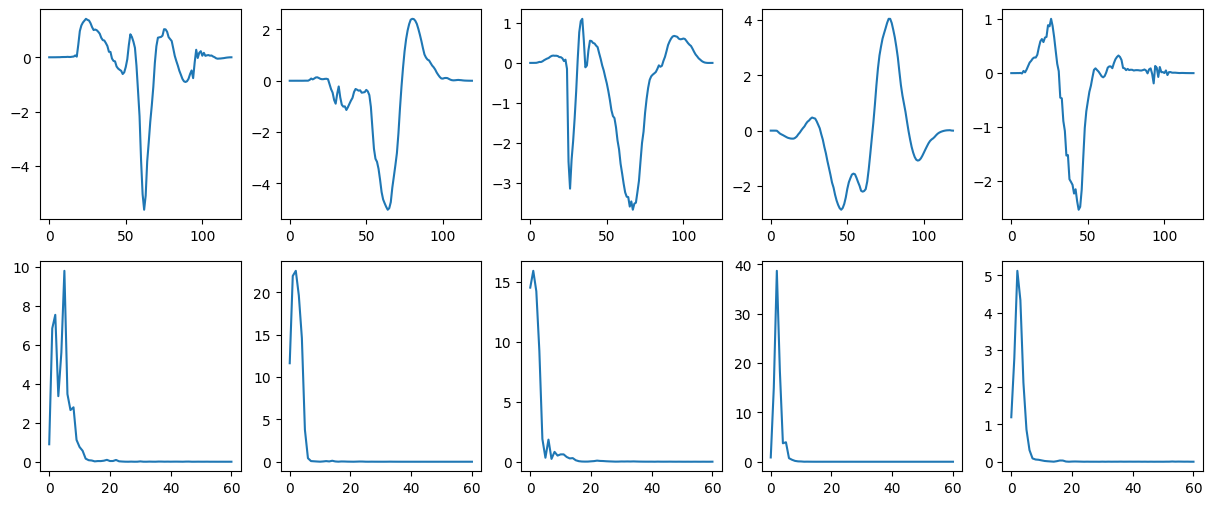

In [108]:
plt.figure(figsize=(15,6))
for i in range(1,6):
    plt.subplot(2,5,i)
    r = aligned_dfs.iloc[i+1]
    r = r['ACC'][:120,1]
    data_arr = r.squeeze()
    h_data_arr = data_arr * np.hanning(len(data_arr))
    h_fft = np.fft.rfft(h_data_arr)
    S = np.abs(h_fft**2)/len(df)
    plt.plot(h_data_arr)
    plt.subplot(2,5,i+5)
    plt.plot(S)